In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy import stats
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from statannotations.Annotator import Annotator

In [2]:
models = ['PDBbind_minimized_v18_subset','PLANet_v18', 'PDBbind_minimized_v18_subset_union_PLANet_v18']
tps = ['cmx', 'lig_alone']

In [3]:
test_dir = '/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/test_result'

In [2]:
PDBbind_whole_property = pd.read_csv('/pubhome/xli02/project/PLIM/analysis/20220812_paper/distribution/property/PDBbind_whole.csv', sep='\t')
PDBbind_whole_property

,pdb_id,-logAffi,mw,logp,rotb,hbd,hba,q,HA
0,3zzf,0.40,187.151,-3.2289,5.0,1.0,5.0,-2.0,13.0
1,3gww,0.45,310.339,3.4088,6.0,1.0,1.0,1.0,22.0
2,1w8l,0.49,141.214,1.2648,0.0,0.0,1.0,0.0,10.0
3,3fqa,0.49,136.130,-0.3677,1.0,1.0,3.0,-1.0,10.0
4,1zsb,0.60,222.251,-0.8561,2.0,2.0,6.0,0.0,13.0
...,...,...,...,...,...,...,...,...,...
17174,7cpa,13.96,580.574,2.5536,14.0,2.0,8.0,-2.0,41.0
17175,2xuf,14.39,658.854,8.6355,12.0,3.0,8.0,0.0,50.0
17176,1avd,15.00,243.308,-0.5379,5.0,2.0,4.0,-1.0,16.0
17177,2xui,15.00,658.854,8.6355,12.0,3.0,8.0,0.0,50.0


In [5]:
PDBbind_hold = pd.read_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/index/minimized/PDBbind_subset/PDBbind_hold_out_2019_subset.csv',  sep='\t')
# PDBbind_hold_prop = pd.merge(PDBbind_whole_property, PDBbind_hold, on=['pdb_id', '-logAffi'])
PDBbind_hold_prop = PDBbind_whole_property[PDBbind_whole_property['pdb_id'].isin(PDBbind_hold['pdb_id'])].copy()
PDBbind_hold_prop

,pdb_id,-logAffi,mw,logp,rotb,hbd,hba,q,HA
168,6gmx,2.17,198.674,3.0185,0.0,0.0,2.0,0.0,12.0
242,6gmq,2.30,173.215,1.9696,2.0,1.0,2.0,0.0,13.0
652,5ye8,3.00,207.201,1.3363,2.0,1.0,2.0,0.0,13.0
655,6ftz,3.00,309.349,1.2610,4.0,4.0,2.0,1.0,23.0
666,6f6n,3.02,307.244,4.1534,2.0,1.0,0.0,1.0,20.0
...,...,...,...,...,...,...,...,...,...
17025,6h5w,10.80,407.537,0.6063,5.0,2.0,6.0,-1.0,27.0
17032,6h5x,10.82,407.537,0.6063,5.0,2.0,6.0,-1.0,27.0
17049,5nn0,10.96,457.662,1.8888,7.0,2.0,1.0,2.0,34.0
17073,5llg,11.13,231.342,1.8361,4.0,1.0,3.0,0.0,14.0


In [6]:
PDBbind_hold_prop[PDBbind_hold_prop['HA']>60]

,pdb_id,-logAffi,mw,logp,rotb,hbd,hba,q,HA


# 1. metrics

In [7]:
mean_pred_df = pd.DataFrame.from_dict({})
label_to_res_dict = defaultdict(list)
for model in models:
    for tp in tps:
        res_df = pd.read_csv(f'{test_dir}/test_on_PDBbind_hold_out_2019/{model}_{tp}/test.csv', sep='\t')
        # print(len(res_df_heavy_atom))
        # res_df_with_prop_Mw_pAffi = res_df_with_prop[(res_df_with_prop['y_true'] < 10) & (res_df_with_prop['y_true'] >0) & (res_df_with_prop['mw'] < 800)].copy()
        for i in range(5):
            r2 = r2_score(y_true=res_df['y_true'], y_pred=res_df[f'{model}_{tp}_{i+1}_pred'])
            mae = mean_absolute_error(y_true=res_df['y_true'], y_pred=res_df[f'{model}_{tp}_{i+1}_pred'])
            mse = mean_squared_error(y_true=res_df['y_true'], y_pred=res_df[f'{model}_{tp}_{i+1}_pred'])
            pearsonr = stats.pearsonr(res_df['y_true'], res_df[f'{model}_{tp}_{i+1}_pred'])[0]
            spearmanr = stats.spearmanr(res_df['y_true'], res_df[f'{model}_{tp}_{i+1}_pred'])[0]
            label_to_res_dict[f'{model}_{tp}_{i+1}']=[r2, mae, mse, pearsonr, spearmanr]

        res_df[f'{model}_{tp}_mean'] = res_df[[f'{model}_{tp}_{i+1}_pred' for i in range(5)]].mean(axis=1)
        if mean_pred_df.empty:
            mean_pred_df = res_df[['unique_identify', 'y_true', f'{model}_{tp}_mean']].copy()
        else:
            mean_pred_df = pd.merge(mean_pred_df, res_df[['unique_identify', 'y_true', f'{model}_{tp}_mean']], on=['unique_identify', 'y_true'])

In [8]:
sum_df = pd.DataFrame.from_dict(label_to_res_dict, orient='index', columns=['r2', 'mae', 'mse', 'pearsonr', 'spearmanr']).reset_index()
sum_df.rename(columns={"index": "model_names_test_type"}, inplace=True)
sum_df['rmse'] = np.sqrt(sum_df['mse'])
sum_df['model_tp'] = sum_df['model_names_test_type'].str.rsplit('_', n=1).str[0]
sum_df['type'] = ['cmx' if 'cmx' in m else 'ligand_alone' for m in sum_df['model_tp']]
sum_df['dataset'] = ['_'.join(m.split('_')[:-1]) if 'cmx' in m else '_'.join(m.split('_')[:-2]) for m in sum_df['model_tp']]
sum_df.to_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/6_models_5_repeats_metrics_heavy_atom_filtered.csv', sep='\t', index=False)
sum_df

,model_names_test_type,r2,mae,mse,pearsonr,spearmanr,rmse,model_tp,type,dataset
0,PDBbind_minimized_v18_subset_cmx_1,0.218450,1.134604,2.107812,0.521171,0.463856,1.451831,PDBbind_minimized_v18_subset_cmx,cmx,PDBbind_minimized_v18_subset
1,PDBbind_minimized_v18_subset_cmx_2,0.213699,1.162458,2.120627,0.527729,0.474857,1.456237,PDBbind_minimized_v18_subset_cmx,cmx,PDBbind_minimized_v18_subset
2,PDBbind_minimized_v18_subset_cmx_3,0.237617,1.141255,2.056120,0.529372,0.484915,1.433918,PDBbind_minimized_v18_subset_cmx,cmx,PDBbind_minimized_v18_subset
3,PDBbind_minimized_v18_subset_cmx_4,0.295014,1.088153,1.901322,0.559171,0.523348,1.378884,PDBbind_minimized_v18_subset_cmx,cmx,PDBbind_minimized_v18_subset
4,PDBbind_minimized_v18_subset_cmx_5,0.263102,1.125871,1.987388,0.561237,0.509915,1.409748,PDBbind_minimized_v18_subset_cmx,cmx,PDBbind_minimized_v18_subset
5,PDBbind_minimized_v18_subset_lig_alone_1,0.175205,1.207853,2.224443,0.444301,0.372846,1.491457,PDBbind_minimized_v18_subset_lig_alone,ligand_alone,PDBbind_minimized_v18_subset
6,PDBbind_minimized_v18_subset_lig_alone_2,0.115297,1.231823,2.386012,0.403839,0.343861,1.544672,PDBbind_minimized_v18_subset_lig_alone,ligand_alone,PDBbind_minimized_v18_subset
7,PDBbind_minimized_v18_subset_lig_alone_3,0.150541,1.209219,2.290961,0.439911,0.368238,1.513592,PDBbind_minimized_v18_subset_lig_alone,ligand_alone,PDBbind_minimized_v18_subset
8,PDBbind_minimized_v18_subset_lig_alone_4,0.139558,1.207477,2.320582,0.427067,0.372774,1.523346,PDBbind_minimized_v18_subset_lig_alone,ligand_alone,PDBbind_minimized_v18_subset
9,PDBbind_minimized_v18_subset_lig_alone_5,0.211405,1.160394,2.126814,0.511374,0.474384,1.458360,PDBbind_minimized_v18_subset_lig_alone,ligand_alone,PDBbind_minimized_v18_subset


In [9]:
grouped_median = sum_df.groupby(['dataset', 'type']).median().reset_index()
grouped_median['model_name'] = [f'{row.dataset}_{row.type}' for row in grouped_median.itertuples()]
grouped_median

,dataset,type,r2,mae,mse,pearsonr,spearmanr,rmse,model_name
0,PDBbind_minimized_v18_subset,cmx,0.237617,1.134604,2.056120,0.529372,0.484915,1.433918,PDBbind_minimized_v18_subset_cmx
1,PDBbind_minimized_v18_subset,ligand_alone,0.150541,1.207853,2.290961,0.439911,0.372774,1.513592,PDBbind_minimized_v18_subset_ligand_alone
2,PDBbind_minimized_v18_subset_union_PLANet_v18,cmx,0.189083,1.158128,2.187015,0.520757,0.488411,1.478856,PDBbind_minimized_v18_subset_union_PLANet_v18_cmx
3,PDBbind_minimized_v18_subset_union_PLANet_v18,ligand_alone,0.085764,1.229949,2.465661,0.439253,0.419083,1.570242,PDBbind_minimized_v18_subset_union_PLANet_v18_...
4,PLANet_v18,cmx,0.191784,1.184616,2.179730,0.501806,0.473343,1.476391,PLANet_v18_cmx
5,PLANet_v18,ligand_alone,0.123956,1.202172,2.362659,0.447012,0.422377,1.537094,PLANet_v18_ligand_alone


# pearsonr

In [41]:
metric='pearsonr'

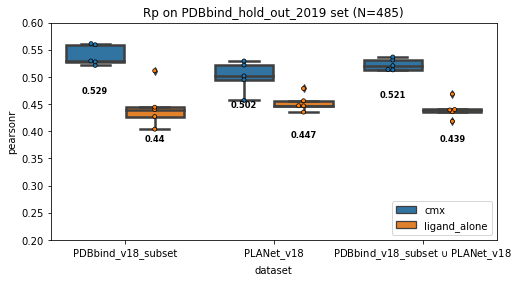

In [14]:
fig, ax= plt.subplots(figsize=(8,4))
sns.boxplot(x="dataset", y=metric, data=sum_df, hue="type", order = models, linewidth=2.5)
sns.swarmplot(x="dataset", y=metric, data=sum_df, hue="type", order = models, size = 4, dodge=True, edgecolor="black", linewidth=0.7)
ax.set_title(f'Rp on PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
# fig.autofmt_xdate()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], loc='lower right')
vertical_offset = sum_df[metric].median() * 0.12 # offset from median for display
for i, modl in enumerate(models):
    for tp in ['cmx', 'ligand_alone']:
        median_metric = round(grouped_median.loc[(grouped_median['model_name'] == f'{modl}_{tp}')][metric].values[0], 3)
        if tp == 'cmx':
            ax.text(i-.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
        else:
            ax.text(i+.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
ax.set_ylim(0.2,0.6)
ax.set_xticklabels(['PDBbind_v18_subset', 'PLANet_v18', 'PDBbind_v18_subset '+r'$\cup{}$' + ' PLANet_v18'])
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/scaled/{metric}_all_5_repeat_models.png', dpi=300, bbox_inches='tight')
# plt.close()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PDBbind_minimized_v18_subset_ligand_alone vs. PLANet_v18_ligand_alone: t-test independent samples, P_val:7.093e-01 t=-3.864e-01
PDBbind_minimized_v18_subset_cmx vs. PLANet_v18_cmx: t-test independent samples, P_val:3.456e-02 t=2.543e+00


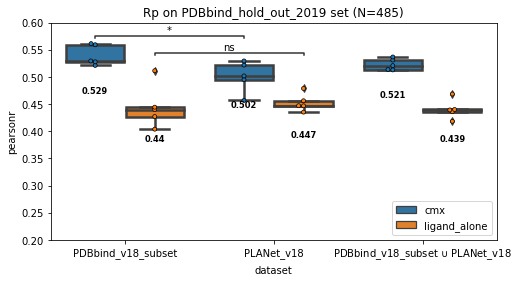

In [44]:
fig, ax= plt.subplots(figsize=(8,4))
sns.boxplot(x="dataset", y=metric, data=sum_df, hue="type", order = models, linewidth=2.5)
sns.swarmplot(x="dataset", y=metric, data=sum_df, hue="type", order = models, size = 4, dodge=True, edgecolor="black", linewidth=0.7)
ax.set_title(f'Rp on PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
# fig.autofmt_xdate()

pairs = [(("PLANet_v18", "ligand_alone"), ("PDBbind_minimized_v18_subset", "ligand_alone")), 
    (("PLANet_v18", "cmx"), ("PDBbind_minimized_v18_subset", "cmx")), 
    # (("PIP", "complex"), ("PIPUP", "complex")),
    # (("PIP", "ligand_alone"), ("PIPUP", "ligand_alone")),
    # (("PDBbind", "cmx"), ("DOCK", "cmx")),
    ]
# add_median_labels(ax.axes)
annotator = Annotator(ax, pairs, x="dataset", y=metric, data=sum_df, hue="type", order = models)
annotator.configure(test='t-test_ind').apply_and_annotate()


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], loc='lower right')
vertical_offset = sum_df[metric].median() * 0.12 # offset from median for display
for i, modl in enumerate(models):
    for tp in ['cmx', 'ligand_alone']:
        median_metric = round(grouped_median.loc[(grouped_median['model_name'] == f'{modl}_{tp}')][metric].values[0], 3)
        if tp == 'cmx':
            ax.text(i-.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
        else:
            ax.text(i+.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
ax.set_ylim(0.2,0.6)
ax.set_xticklabels(['PDBbind_v18_subset', 'PLANet_v18', 'PDBbind_v18_subset '+r'$\cup{}$' + ' PLANet_v18'])
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/scaled/{metric}_all_5_repeat_models_with_sig.png', dpi=300, bbox_inches='tight')
# plt.close()

# spearmanr

In [15]:
metric='spearmanr'

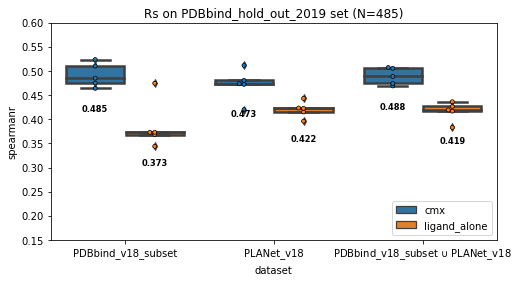

In [16]:
fig, ax= plt.subplots(figsize=(8,4))
sns.boxplot(x="dataset", y=metric, data=sum_df, hue="type", order = models, linewidth=2.5)
sns.swarmplot(x="dataset", y=metric, data=sum_df, hue="type", order = models, size = 4, dodge=True, edgecolor="black", linewidth=0.7)
ax.set_title(f'Rs on PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
# fig.autofmt_xdate()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], loc='lower right')
vertical_offset = sum_df[metric].median() * 0.15 # offset from median for display
for i, modl in enumerate(models):
    for tp in ['cmx', 'ligand_alone']:
        median_metric = round(grouped_median.loc[(grouped_median['model_name'] == f'{modl}_{tp}')][metric].values[0], 3)
        if tp == 'cmx':
            ax.text(i-.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
        else:
            ax.text(i+.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
ax.set_ylim(0.15,0.6)
ax.set_xticklabels(['PDBbind_v18_subset', 'PLANet_v18', 'PDBbind_v18_subset '+r'$\cup{}$' + ' PLANet_v18'])
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/scaled/{metric}_all_5_repeat_models.png', dpi=300, bbox_inches='tight')
# plt.close()

# rmse

In [17]:
metric='rmse'

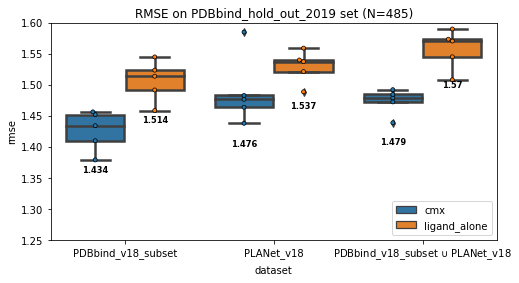

In [19]:
fig, ax= plt.subplots(figsize=(8,4))
sns.boxplot(x="dataset", y=metric, data=sum_df, hue="type", order = models, linewidth=2.5)
sns.swarmplot(x="dataset", y=metric, data=sum_df, hue="type", order = models, size = 4, dodge=True, edgecolor="black", linewidth=0.7)
ax.set_title(f'RMSE on PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
# fig.autofmt_xdate()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], loc='lower right')
vertical_offset = sum_df[metric].median() * 0.05 # offset from median for display
for i, modl in enumerate(models):
    for tp in ['cmx', 'ligand_alone']:
        median_metric = round(grouped_median.loc[(grouped_median['model_name'] == f'{modl}_{tp}')][metric].values[0], 3)
        if tp == 'cmx':
            ax.text(i-.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
        else:
            ax.text(i+.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
ax.set_ylim(1.25,1.6)
ax.set_xticklabels(['PDBbind_v18_subset', 'PLANet_v18', 'PDBbind_v18_subset '+r'$\cup{}$' + ' PLANet_v18'])
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/scaled/{metric}_all_5_repeat_models.png', dpi=300, bbox_inches='tight')
# plt.close()

# mae

In [176]:
metric='mae'

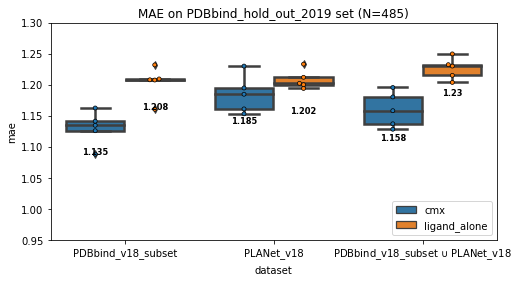

In [23]:
fig, ax= plt.subplots(figsize=(8,4))
sns.boxplot(x="dataset", y=metric, data=sum_df, hue="type", order = models, linewidth=2.5)
sns.swarmplot(x="dataset", y=metric, data=sum_df, hue="type", order = models, size = 4, dodge=True, edgecolor="black", linewidth=0.7)
ax.set_title(f'MAE on PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
# fig.autofmt_xdate()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], loc='lower right')
vertical_offset = sum_df[metric].median() * 0.04 # offset from median for display
for i, modl in enumerate(models):
    for tp in ['cmx', 'ligand_alone']:
        median_metric = round(grouped_median.loc[(grouped_median['model_name'] == f'{modl}_{tp}')][metric].values[0], 3)
        if tp == 'cmx':
            ax.text(i-.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
        else:
            ax.text(i+.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
ax.set_ylim(0.95,1.3)
ax.set_xticklabels(['PDBbind_v18_subset', 'PLANet_v18', 'PDBbind_v18_subset '+r'$\cup{}$' + ' PLANet_v18'])
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/scaled/{metric}_all_5_repeat_models.png', dpi=300, bbox_inches='tight')
# plt.close()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PDBbind_minimized_v18_subset_ligand_alone vs. PLANet_v18_ligand_alone: t-test independent samples, P_val:7.290e-01 t=-3.589e-01
PDBbind_minimized_v18_subset_cmx vs. PLANet_v18_cmx: t-test independent samples, P_val:1.796e-02 t=-2.967e+00


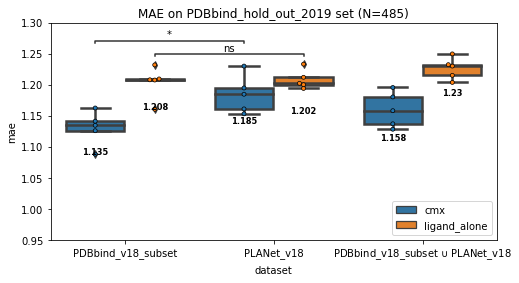

In [177]:
fig, ax= plt.subplots(figsize=(8,4))
sns.boxplot(x="dataset", y=metric, data=sum_df, hue="type", order = models, linewidth=2.5)
sns.swarmplot(x="dataset", y=metric, data=sum_df, hue="type", order = models, size = 4, dodge=True, edgecolor="black", linewidth=0.7)
ax.set_title(f'MAE on PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
# fig.autofmt_xdate()

pairs = [(("PLANet_v18", "ligand_alone"), ("PDBbind_minimized_v18_subset", "ligand_alone")), 
    (("PLANet_v18", "cmx"), ("PDBbind_minimized_v18_subset", "cmx")), 
    ]
annotator = Annotator(ax, pairs, x="dataset", y=metric, data=sum_df, hue="type", order = models)
annotator.configure(test='t-test_ind').apply_and_annotate()

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], loc='lower right')
vertical_offset = sum_df[metric].median() * 0.04 # offset from median for display
for i, modl in enumerate(models):
    for tp in ['cmx', 'ligand_alone']:
        median_metric = round(grouped_median.loc[(grouped_median['model_name'] == f'{modl}_{tp}')][metric].values[0], 3)
        if tp == 'cmx':
            ax.text(i-.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
        else:
            ax.text(i+.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
ax.set_ylim(0.95,1.3)
ax.set_xticklabels(['PDBbind_v18_subset', 'PLANet_v18', 'PDBbind_v18_subset '+r'$\cup{}$' + ' PLANet_v18'])
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/scaled/{metric}_all_5_repeat_models_with_sig.png', dpi=300, bbox_inches='tight')
# plt.close()

# 2. mean of 5 models

In [24]:
mean_pred_df.to_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/6models.csv', sep='\t', index=False)
mean_pred_df

,unique_identify,y_true,PDBbind_minimized_v18_subset_cmx_mean,PDBbind_minimized_v18_subset_lig_alone_mean,PLANet_v18_cmx_mean,PLANet_v18_lig_alone_mean,PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean,PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean
0,5eng,5.85,6.118464,6.980225,5.603281,6.466641,5.494726,6.591030
1,5ep7,5.40,4.287641,5.439884,5.191231,5.011604,5.331327,4.955045
2,5fxq,7.85,7.900875,8.166469,6.518389,7.342149,6.674024,8.371089
3,5fxs,8.05,7.926687,8.313922,7.159188,7.725515,7.583177,7.946747
4,5g2b,7.00,8.864078,8.259109,7.725052,6.264232,7.630954,7.382459
...,...,...,...,...,...,...,...,...
476,6m9t,7.70,8.029396,7.308245,7.126153,6.324770,6.823287,7.008233
477,6ma5,8.10,6.220125,6.668172,7.052922,6.141025,6.013798,6.417132
478,6mrg,7.55,7.243981,7.061430,6.272728,6.625929,6.729782,6.603834
479,6mx8,9.43,7.624122,7.440676,7.899214,8.114034,8.136658,8.277246


In [10]:
res_dict={}
for model in models:
    for tp in tps:
        r2 = r2_score(y_true=mean_pred_df['y_true'], y_pred=mean_pred_df[f'{model}_{tp}_mean'])
        mae = mean_absolute_error(y_true=mean_pred_df['y_true'], y_pred=mean_pred_df[f'{model}_{tp}_mean'])
        mse = mean_squared_error(y_true=mean_pred_df['y_true'], y_pred=mean_pred_df[f'{model}_{tp}_mean'])
        pearsonr = stats.pearsonr(mean_pred_df['y_true'], mean_pred_df[f'{model}_{tp}_mean'])[0]
        spearmanr = stats.spearmanr(mean_pred_df['y_true'], mean_pred_df[f'{model}_{tp}_mean'])[0]
        res_dict[f'{model}_{tp}']=[r2, mae, mse, pearsonr, spearmanr]

com_sum_df = pd.DataFrame.from_dict(res_dict, orient='index', columns=['r2', 'mae', 'mse', 'pearsonr', 'spearmanr']).reset_index()
com_sum_df.rename(columns={"index": "model_names_test_type"}, inplace=True)
com_sum_df['type'] = ['cmx' if 'cmx' in m else 'lig_alone' for m in com_sum_df['model_names_test_type']]
com_sum_df['dataset'] = ['_'.join(m.split('_')[:-1]) if 'cmx' in m else '_'.join(m.split('_')[:-2]) for m in com_sum_df['model_names_test_type']]
com_sum_df.to_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/6models_metric.csv', sep='\t', index=False)
com_sum_df

,model_names_test_type,r2,mae,mse,pearsonr,spearmanr,type,dataset
0,PDBbind_minimized_v18_subset_cmx,0.312843,1.076394,1.853238,0.575765,0.528389,cmx,PDBbind_minimized_v18_subset
1,PDBbind_minimized_v18_subset_lig_alone,0.207935,1.168104,2.136171,0.482120,0.419428,lig_alone,PDBbind_minimized_v18_subset
2,PLANet_v18_cmx,0.308635,1.086566,1.864588,0.580389,0.545400,cmx,PLANet_v18
3,PLANet_v18_lig_alone,0.280448,1.105376,1.940607,0.541992,0.506544,lig_alone,PLANet_v18
4,PDBbind_minimized_v18_subset_union_PLANet_v18_cmx,0.319284,1.075541,1.835868,0.595776,0.558677,cmx,PDBbind_minimized_v18_subset_union_PLANet_v18
5,PDBbind_minimized_v18_subset_union_PLANet_v18_...,0.267471,1.112632,1.975604,0.531006,0.513781,lig_alone,PDBbind_minimized_v18_subset_union_PLANet_v18


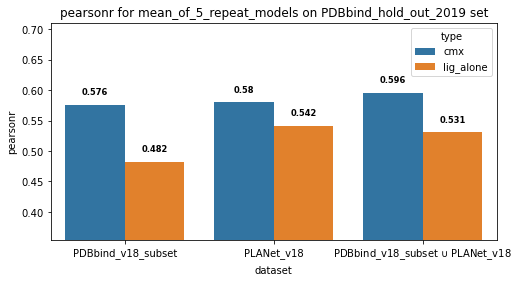

In [28]:
metric='pearsonr'
fig, ax= plt.subplots(figsize=(8,4))
sns.barplot(x="dataset", y=metric, hue='type', data=com_sum_df)

ax.set_title(f'{metric} for mean_of_5_repeat_models on PDBbind_hold_out_2019 set')
vertical_offset = com_sum_df[metric].median() * 0.03 # offset from median for display
for i, modl in enumerate(models):
    for tp in ['cmx', 'lig_alone']:
        median_metric = round(com_sum_df.loc[(com_sum_df['model_names_test_type'] == f'{modl}_{tp}')][metric].values[0], 3)
        if tp == 'cmx':
            ax.text(i-.2, median_metric+vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
        else:
            ax.text(i+.2, median_metric+vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
ax.set_ylim(min(sum_df[metric])-0.05, min(max(sum_df[metric])+0.15, 1))
ax.set_xticklabels(['PDBbind_v18_subset', 'PLANet_v18', 'PDBbind_v18_subset '+r'$\cup{}$' + ' PLANet_v18'])
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/{metric}_mean_of_5_repeat_models.png', dpi=300, bbox_inches='tight')
# plt.close()

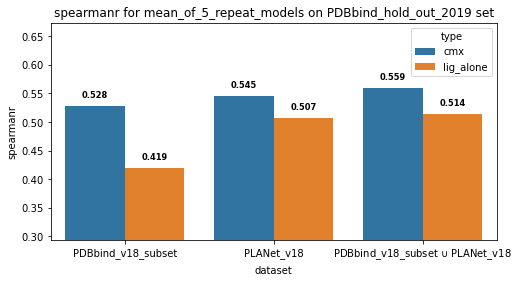

In [29]:
metric='spearmanr'
fig, ax= plt.subplots(figsize=(8,4))
sns.barplot(x="dataset", y=metric, hue='type', data=com_sum_df)

ax.set_title(f'{metric} for mean_of_5_repeat_models on PDBbind_hold_out_2019 set')
vertical_offset = com_sum_df[metric].median() * 0.03 # offset from median for display
for i, modl in enumerate(models):
    for tp in ['cmx', 'lig_alone']:
        median_metric = round(com_sum_df.loc[(com_sum_df['model_names_test_type'] == f'{modl}_{tp}')][metric].values[0], 3)
        if tp == 'cmx':
            ax.text(i-.2, median_metric+vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
        else:
            ax.text(i+.2, median_metric+vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
ax.set_ylim(min(sum_df[metric])-0.05, min(max(sum_df[metric])+0.15, 1))
ax.set_xticklabels(['PDBbind_v18_subset', 'PLANet_v18', 'PDBbind_v18_subset '+r'$\cup{}$' + ' PLANet_v18'])
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/{metric}_mean_of_5_repeat_models.png', dpi=300, bbox_inches='tight')
# plt.close()

# 2.1 mean_pred - Experimental pAffi 散点图

In [11]:
from scipy.stats import gaussian_kde

In [12]:
simple_dict = {'PDBbind_minimized_v18_subset':'PDBbind_v18_subset', 'PDBbind_minimized_v18_subset_union_PLANet_v18':'PDBbind_v18_subset '+r'$\cup{}$' + ' PLANet_v18','PLANet_v18':'PLANet_v18'}

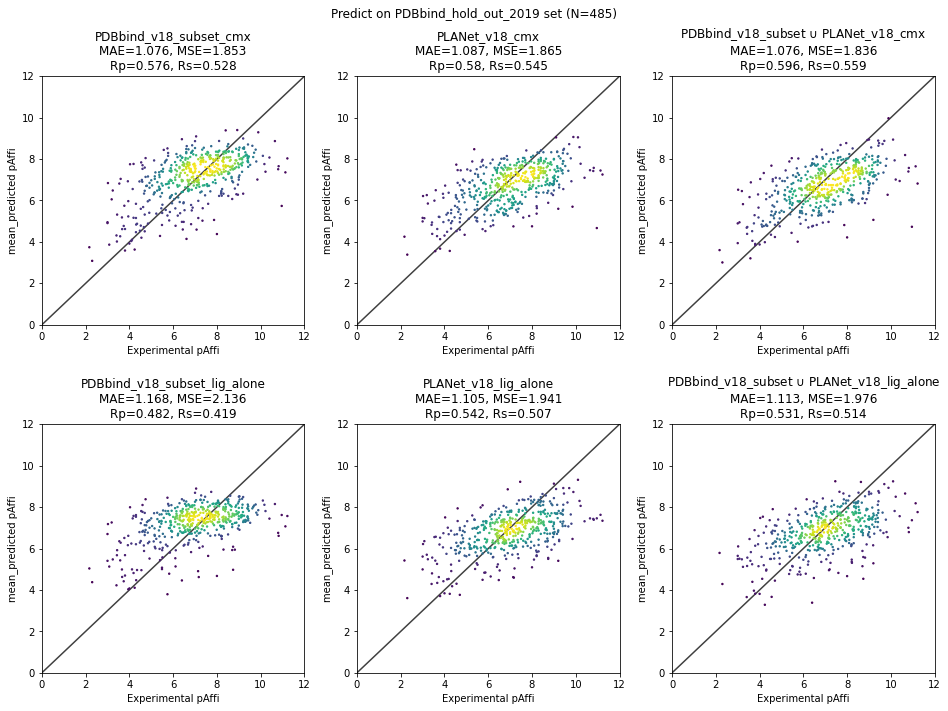

In [32]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        y_true = mean_pred_df['y_true']
        y_pred = mean_pred_df[f'{model}_{tp}_mean']

        xy = np.vstack([y_true.T, y_pred.T])
        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        y_true_, y_pred_, z = y_true[idx], y_pred[idx], z[idx]

        #https://github.com/hnlab/handbook/blob/41ad374cd0f9dc3ef882a7724eaac3d1f748fc05/0-General-computing-skills/MISC/vsfig.py#L83-L134
        # fig, ax = plt.subplots()
        ax.scatter(y_true_, y_pred_, s=2, c=z, zorder=2)

        # sns.scatterplot(x='y_true', y=f'{model}_{tp}_mean', data=mean_pred_df)
        lims = [0,12]
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('Experimental pAffi')
        ax.set_title(f'{simple_dict[model]}_{tp}\nMAE={round(com_sum_df[com_sum_df["model_names_test_type"]==f"{model}_{tp}"]["mae"].values[0], 3)}, MSE={round(com_sum_df[com_sum_df["model_names_test_type"]==f"{model}_{tp}"]["mse"].values[0], 3)}\nRp={round(com_sum_df[com_sum_df["model_names_test_type"]==f"{model}_{tp}"]["pearsonr"].values[0], 3)}, Rs={round(com_sum_df[com_sum_df["model_names_test_type"]==f"{model}_{tp}"]["spearmanr"].values[0], 3)}')
# plt.subplots_adjust(left=0.125,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.87, 
#                     wspace=1, 
#                     hspace=0.8)
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.92, 
                    wspace=0.2, 
                    hspace=0.4)
plt.suptitle(f'Predict on PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/scatter_6_models.png', dpi=300, bbox_inches='tight')

# 2.2 Mw-mean_pred_pAffi

In [13]:
mean_pred_df_with_prop = pd.merge(mean_pred_df.round({'y_true': 2}), PDBbind_hold_prop.rename(columns={'pdb_id':'unique_identify', '-logAffi':'y_true'}), on=['unique_identify', 'y_true'])
mean_pred_df_with_prop

,unique_identify,y_true,PDBbind_minimized_v18_subset_cmx_mean,PDBbind_minimized_v18_subset_lig_alone_mean,PLANet_v18_cmx_mean,PLANet_v18_lig_alone_mean,PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean,PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean,mw,logp,rotb,hbd,hba,q,HA
0,5eng,5.85,6.118464,6.980225,5.603281,6.466641,5.494726,6.591030,471.554,0.16750,10.0,3.0,6.0,2.0,34.0
1,5ep7,5.40,4.287641,5.439884,5.191231,5.011604,5.331327,4.955045,271.252,0.00110,3.0,1.0,5.0,-1.0,20.0
2,5fxq,7.85,7.900875,8.166469,6.518389,7.342149,6.674024,8.371089,409.905,2.59152,4.0,2.0,7.0,1.0,29.0
3,5fxs,8.05,7.926687,8.313922,7.159188,7.725515,7.583177,7.946747,509.038,2.30964,6.0,2.0,8.0,1.0,36.0
4,5g2b,7.00,8.864078,8.259109,7.725052,6.264232,7.630954,7.382459,528.653,4.42880,7.0,2.0,5.0,0.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,6m9t,7.70,8.029396,7.308245,7.126153,6.324770,6.823287,7.008233,367.506,2.53050,13.0,2.0,5.0,-1.0,26.0
477,6ma5,8.10,6.220125,6.668172,7.052922,6.141025,6.013798,6.417132,540.599,1.39650,10.0,2.0,8.0,-1.0,37.0
478,6mrg,7.55,7.243981,7.061430,6.272728,6.625929,6.729782,6.603834,349.390,3.06030,5.0,2.0,6.0,0.0,26.0
479,6mx8,9.43,7.624122,7.440676,7.899214,8.114034,8.136658,8.277246,586.121,2.25580,8.0,4.0,7.0,2.0,40.0


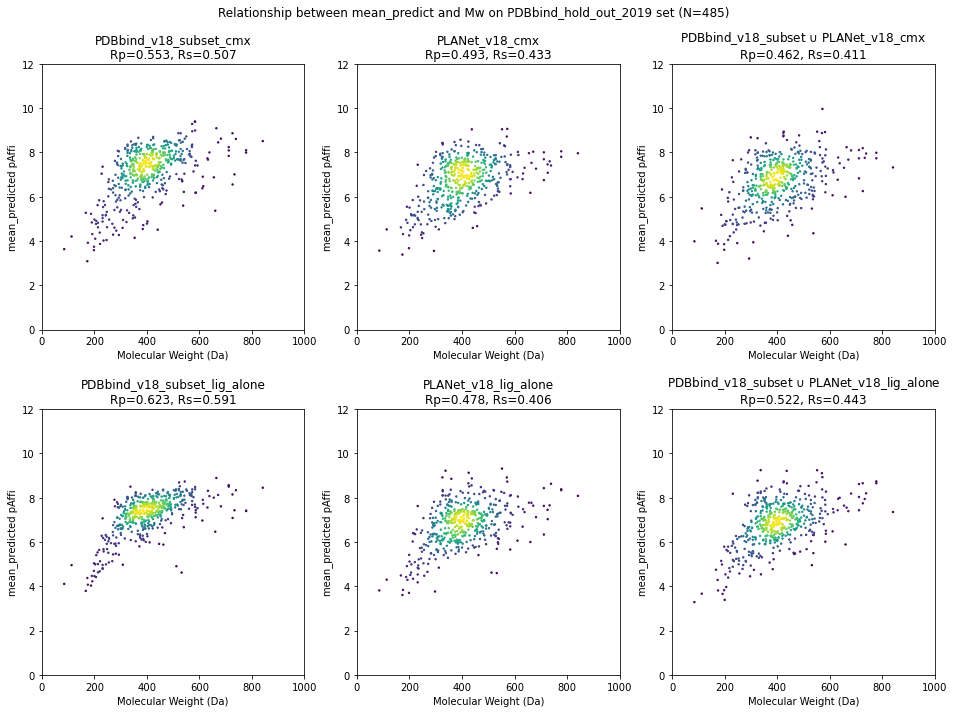

In [35]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))

        y_true = mean_pred_df_with_prop['mw']
        y_pred = mean_pred_df_with_prop[f'{model}_{tp}_mean']

        xy = np.vstack([y_true.T, y_pred.T])
        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        y_true_, y_pred_, z = y_true[idx], y_pred[idx], z[idx]

        #https://github.com/hnlab/handbook/blob/41ad374cd0f9dc3ef882a7724eaac3d1f748fc05/0-General-computing-skills/MISC/vsfig.py#L83-L134
        # fig, ax = plt.subplots()
        ax.scatter(y_true_, y_pred_, s=2, c=z, zorder=2)

        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=mean_pred_df_with_prop)

        # if model=='PDBbind_minimized_intersected_Uw':
        #     ax.axvline(x=800, color='black', linestyle='--')

        ax.set_xlim(0, 1000)
        ax.set_ylim(0, 12)

        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('Molecular Weight (Da)')
        ax.set_title(f'{simple_dict[model]}_{tp}\nRp={round(stats.pearsonr(mean_pred_df_with_prop[f"{model}_{tp}_mean"], mean_pred_df_with_prop["mw"])[0], 3)}, Rs={round(stats.spearmanr(mean_pred_df_with_prop[f"{model}_{tp}_mean"], mean_pred_df_with_prop["mw"])[0], 3)}')
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.3)
plt.suptitle(f'Relationship between mean_predict and Mw on PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/mw/scatter_for_12_models.png', dpi=300, bbox_inches='tight')

# 2.3 HA

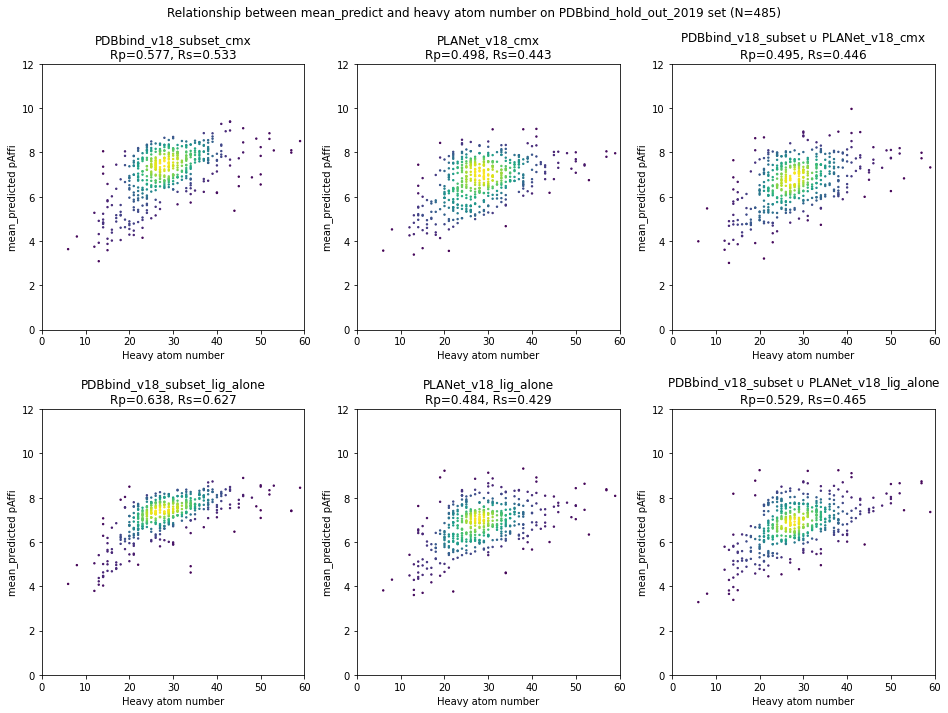

In [14]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))

        y_true = mean_pred_df_with_prop['HA']
        y_pred = mean_pred_df_with_prop[f'{model}_{tp}_mean']

        xy = np.vstack([y_true.T, y_pred.T])
        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        y_true_, y_pred_, z = y_true[idx], y_pred[idx], z[idx]

        #https://github.com/hnlab/handbook/blob/41ad374cd0f9dc3ef882a7724eaac3d1f748fc05/0-General-computing-skills/MISC/vsfig.py#L83-L134
        # fig, ax = plt.subplots()
        ax.scatter(y_true_, y_pred_, s=2, c=z, zorder=2)

        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=mean_pred_df_with_prop)

        # if model=='PDBbind_minimized_intersected_Uw':
        #     ax.axvline(x=800, color='black', linestyle='--')

        ax.set_xlim(0, 60)
        ax.set_ylim(0, 12)

        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('Heavy atom number')
        ax.set_title(f'{simple_dict[model]}_{tp}\nRp={round(stats.pearsonr(mean_pred_df_with_prop[f"{model}_{tp}_mean"], mean_pred_df_with_prop["HA"])[0], 3)}, Rs={round(stats.spearmanr(mean_pred_df_with_prop[f"{model}_{tp}_mean"], mean_pred_df_with_prop["HA"])[0], 3)}')
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.3)
plt.suptitle(f'Relationship between mean_predict and heavy atom number on PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/HA/scatter_for_12_models.png', dpi=300, bbox_inches='tight')

# 2.4 SASA

In [7]:
PDBbind_whole_sasa = pd.read_csv('/pubhome/xli02/project/PLIM/analysis/20220812_paper/SASA/PDBbind_whole_sasa.csv')
len(PDBbind_whole_sasa)

17176

In [179]:
min(PDBbind_whole_sasa['del_sasa'])

0.0

In [180]:
max(PDBbind_whole_sasa['del_sasa'])

29.73399353027344

In [18]:
len(mean_pred_df_with_prop)

481

In [19]:
mean_pred_df_with_prop_sasa = pd.merge(mean_pred_df_with_prop, PDBbind_whole_sasa.rename(columns={'unique_identity':'unique_identify'}), on=['unique_identify'])
mean_pred_df_with_prop_sasa

,unique_identify,y_true,PDBbind_minimized_v18_subset_cmx_mean,PDBbind_minimized_v18_subset_lig_alone_mean,PLANet_v18_cmx_mean,PLANet_v18_lig_alone_mean,PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean,PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean,mw,logp,rotb,hbd,hba,q,HA,lig_sasa,rec_sasa,com_sasa,del_sasa
0,5eng,5.85,6.118464,6.980225,5.603281,6.466641,5.494726,6.591030,471.554,0.16750,10.0,3.0,6.0,2.0,34.0,8.287605,71.745308,71.460564,8.572350
1,5ep7,5.40,4.287641,5.439884,5.191231,5.011604,5.331327,4.955045,271.252,0.00110,3.0,1.0,5.0,-1.0,20.0,4.876276,78.049995,76.987671,5.938599
2,5fxq,7.85,7.900875,8.166469,6.518389,7.342149,6.674024,8.371089,409.905,2.59152,4.0,2.0,7.0,1.0,29.0,6.387094,161.946030,160.403351,7.929779
3,5fxs,8.05,7.926687,8.313922,7.159188,7.725515,7.583177,7.946747,509.038,2.30964,6.0,2.0,8.0,1.0,36.0,7.777926,168.184967,167.182281,8.780609
4,5g2b,7.00,8.864078,8.259109,7.725052,6.264232,7.630954,7.382459,528.653,4.42880,7.0,2.0,5.0,0.0,39.0,8.868021,148.119659,144.279205,12.708481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,6m9t,7.70,8.029396,7.308245,7.126153,6.324770,6.823287,7.008233,367.506,2.53050,13.0,2.0,5.0,-1.0,26.0,7.006455,234.757690,232.058609,9.705536
477,6ma5,8.10,6.220125,6.668172,7.052922,6.141025,6.013798,6.417132,540.599,1.39650,10.0,2.0,8.0,-1.0,37.0,6.863235,281.540466,280.290039,8.113647
478,6mrg,7.55,7.243981,7.061430,6.272728,6.625929,6.729782,6.603834,349.390,3.06030,5.0,2.0,6.0,0.0,26.0,6.143871,201.874634,198.951157,9.067352
479,6mx8,9.43,7.624122,7.440676,7.899214,8.114034,8.136658,8.277246,586.121,2.25580,8.0,4.0,7.0,2.0,40.0,9.120670,136.680237,134.974640,10.826263


In [186]:
mean_pred_df_with_prop_sasa.columns

Index(['unique_identify', 'y_true', 'PDBbind_minimized_v18_subset_cmx_mean',
       'PDBbind_minimized_v18_subset_lig_alone_mean', 'PLANet_v18_cmx_mean',
       'PLANet_v18_lig_alone_mean',
       'PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean',
       'PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean', 'mw',
       'logp', 'rotb', 'hbd', 'hba', 'q', 'HA', 'lig_sasa', 'rec_sasa',
       'com_sasa', 'del_sasa'],
      dtype='object')

In [20]:
min(mean_pred_df_with_prop_sasa['del_sasa'])

2.9868621826171875

In [21]:
max(mean_pred_df_with_prop_sasa['del_sasa'])

15.08477783203125

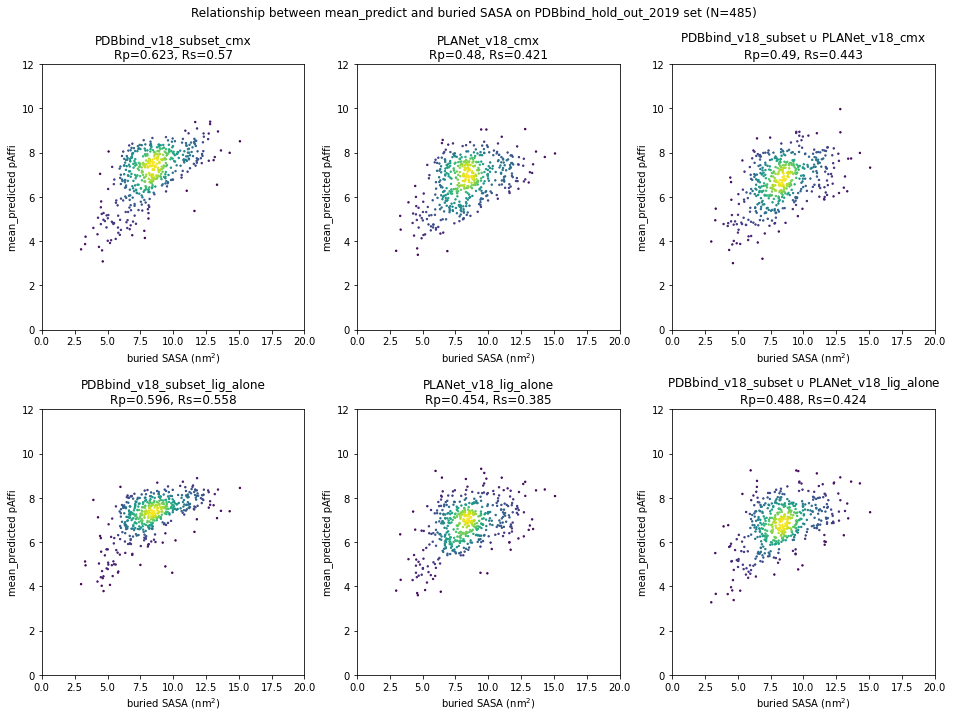

In [24]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))

        y_true = mean_pred_df_with_prop_sasa['del_sasa']
        y_pred = mean_pred_df_with_prop_sasa[f'{model}_{tp}_mean']

        xy = np.vstack([y_true.T, y_pred.T])
        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        y_true_, y_pred_, z = y_true[idx], y_pred[idx], z[idx]

        #https://github.com/hnlab/handbook/blob/41ad374cd0f9dc3ef882a7724eaac3d1f748fc05/0-General-computing-skills/MISC/vsfig.py#L83-L134
        # fig, ax = plt.subplots()
        ax.scatter(y_true_, y_pred_, s=2, c=z, zorder=2)

        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=mean_pred_df_with_prop)

        # if model=='PDBbind_minimized_intersected_Uw':
        #     ax.axvline(x=800, color='black', linestyle='--')

        ax.set_xlim(0, 20)
        ax.set_ylim(0, 12)

        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('buried SASA (nm$\mathregular{^2}$)')
        ax.set_title(f'{simple_dict[model]}_{tp}\nRp={round(stats.pearsonr(mean_pred_df_with_prop_sasa[f"{model}_{tp}_mean"], mean_pred_df_with_prop_sasa["del_sasa"])[0], 3)}, Rs={round(stats.spearmanr(mean_pred_df_with_prop_sasa[f"{model}_{tp}_mean"], mean_pred_df_with_prop_sasa["del_sasa"])[0], 3)}')
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.3)
plt.suptitle(f'Relationship between mean_predict and buried SASA on PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/SASA/scatter_for_12_models.png', dpi=300, bbox_inches='tight')

# 2.5 logp

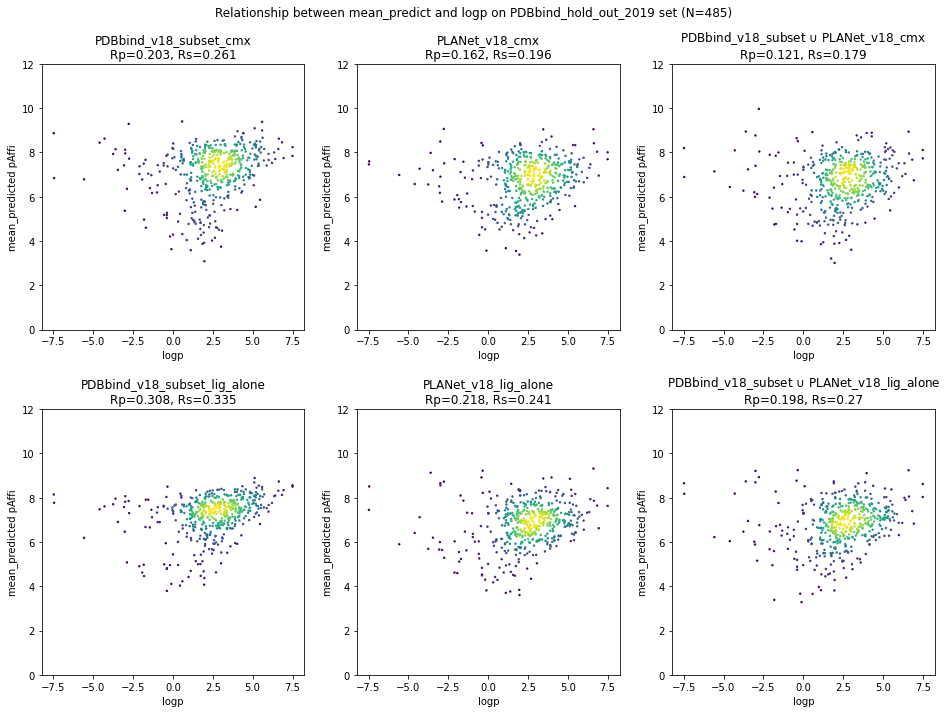

In [25]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))

        y_true = mean_pred_df_with_prop['logp']
        y_pred = mean_pred_df_with_prop[f'{model}_{tp}_mean']

        xy = np.vstack([y_true.T, y_pred.T])
        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        y_true_, y_pred_, z = y_true[idx], y_pred[idx], z[idx]

        #https://github.com/hnlab/handbook/blob/41ad374cd0f9dc3ef882a7724eaac3d1f748fc05/0-General-computing-skills/MISC/vsfig.py#L83-L134
        # fig, ax = plt.subplots()
        ax.scatter(y_true_, y_pred_, s=2, c=z, zorder=2)

        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=mean_pred_df_with_prop)

        # if model=='PDBbind_minimized_intersected_Uw':
        #     ax.axvline(x=800, color='black', linestyle='--')

        # ax.set_xlim(0, 60)
        ax.set_ylim(0, 12)

        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('logp')
        ax.set_title(f'{simple_dict[model]}_{tp}\nRp={round(stats.pearsonr(mean_pred_df_with_prop[f"{model}_{tp}_mean"], mean_pred_df_with_prop["logp"])[0], 3)}, Rs={round(stats.spearmanr(mean_pred_df_with_prop[f"{model}_{tp}_mean"], mean_pred_df_with_prop["logp"])[0], 3)}')
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.3)
plt.suptitle(f'Relationship between mean_predict and logp on PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/logp/scatter_for_12_models.png', dpi=300, bbox_inches='tight')

# 3. 相似性

In [45]:
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Draw, AllChem
from rdkit import DataStructs

In [46]:
pdbbind_dir = '/pubhome/xli02/Downloads/dataset/PDBbind/PDBbind_v2019'

In [47]:
def obtain_training_fps(data_df, dataset_name):
    mols = []
    mol_fps = []
    skipped_mols = []
    for row in data_df.itertuples():
        if 'pdb_id' in data_df.columns.values:
            uniq_id = row.pdb_id
            lig_file = f'{pdbbind_dir}/general_structure_only/{uniq_id}/{uniq_id}_ligand.smi'
            if not Path(lig_file).exists():
                print(f'{uniq_id} of PDBbind not exsits, skipped.')
                skipped_mols.append(uniq_id)
                continue
            compnd_mol = Chem.SmilesMolSupplier(lig_file, delimiter='\t', titleLine=False)[0]
        else:
            uniq_id = row.unique_identify
            if '_' in uniq_id:
                if uniq_id not in list(PLANet_property['unique_identify']):
                    print(f'{uniq_id} of PLANet not exsits in smiles_df, skipped.')
                    skipped_mols.append(uniq_id)
                    continue
                compnd_smi = PLANet_property[PLANet_property['unique_identify']==uniq_id]['Similar_compnd_smiles'].values[0]
                compnd_mol = Chem.MolFromSmiles(compnd_smi)
            else:
                lig_file = f'{pdbbind_dir}/general_structure_only/{uniq_id}/{uniq_id}_ligand.smi'
                if not Path(lig_file).exists():
                    print(f'{uniq_id} of PDBbind not exsits, skipped.')
                    skipped_mols.append(uniq_id)
                    continue
                compnd_mol = Chem.SmilesMolSupplier(lig_file, delimiter='\t', titleLine=False)[0]
        if compnd_mol is None:
            print(f'For compounds in {dataset_name}, {uniq_id} cannot be read by rdkit, skipped.')
            skipped_mols.append(uniq_id)
            continue
        compnd_mol.SetProp('_Name', uniq_id)
        mols.append(compnd_mol)
        mol_fps.append(rdMolDescriptors.GetMorganFingerprintAsBitVect(compnd_mol,2))
    return mols, mol_fps

In [48]:
def calculate_simi(hold_2019_mols, hold_2019_mol_fps, hold_2019_df, mols_2, mol_fps_2, affi_df_2, set_name_1, set_name_2):
    max_simi_for_hold_2019_mols = []
    cols = [f'{set_name_1}_name', f'{set_name_1}_affi', f'{set_name_1}_smiles', f'{set_name_2}_cpnd_name', f'{set_name_2}_cpnd_affi', f'{set_name_2}_cpnd_smiles', 'similarity']
    lst = []
    for i, mol in enumerate(hold_2019_mols):
        simi_list = DataStructs.BulkTanimotoSimilarity(hold_2019_mol_fps[i], mol_fps_2)
        mol_name = mol.GetProp('_Name')
        for j,simi in enumerate(simi_list):
            if simi > 0.8:
                # mol_affi = hold_2019_df[hold_2019_df['pdb_id']==mol_name]['-logAffi'].values[0]
                if 'pdb_id' in hold_2019_df.columns.values:
                    mol_affi = hold_2019_df[hold_2019_df['pdb_id']==mol_name]['-logAffi'].values[0]
                else:
                    mol_affi = hold_2019_df[hold_2019_df['unique_identify']==mol_name]['-logAffi'].values[0]
                mol_smiles = Chem.MolToSmiles(mol)
                mol_2_name = mols_2[j].GetProp('_Name')
                if 'pdb_id' in affi_df_2.columns.values:
                    mol_2_affi = affi_df_2[affi_df_2['pdb_id']==mol_2_name]['-logAffi'].values[0]
                else:
                    mol_2_affi = affi_df_2[affi_df_2['unique_identify']==mol_2_name]['-logAffi'].values[0]
                mol_2_smiles = Chem.MolToSmiles(mols_2[j])
                lst.append([mol_name, mol_affi, mol_smiles, mol_2_name, mol_2_affi, mol_2_smiles, simi])
        max_simi = max(simi_list)
        max_simi_for_hold_2019_mols.append(max_simi)
    out_dir = f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/similarity/{set_name_2}_in_{set_name_1}'
    if not Path(out_dir).exists():
        Path(out_dir).mkdir(parents=True)
    simi_8_df = pd.DataFrame(lst, columns=cols)
    simi_8_df.to_csv(f'{out_dir}/simi_0.8.csv', sep='\t', index=False)
    print(f'For {set_name_1}, there are {max_simi_for_hold_2019_mols.count(1)} / {len(max_simi_for_hold_2019_mols)} PDB IDs same as(similarity=1, not considering chirality) {set_name_2}.')
    print(f'similarity > 0.8: {len([n for n in max_simi_for_hold_2019_mols if n>0.8])} / {len(max_simi_for_hold_2019_mols)}')
    return max_simi_for_hold_2019_mols

# PDBbind_v18_subset whole set

In [ ]:
PDBbind_v18_subset_df = pd.read_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/index/rm_all_simi_1/PDBbind_v18_subset_rm_simi_1.csv', sep='\t')
PDBbind_v18_subset_mols, PDBbind_v18_subset_mol_fps = obtain_training_fps(PDBbind_v18_subset_df, 'PDBbind_v18_subset')

In [50]:
len(PDBbind_v18_subset_df)

5371

In [174]:
len(PDBbind_v18_subset_mols)

NameError: name 'PDBbind_v18_subset_mols' is not defined

# PLANet_v18 whole set

In [54]:
PLANet_v18_df = pd.read_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/index/rm_all_simi_1/PLANet_v18_rm_simi_1.csv', sep='\t')

In [55]:
PLANet_property = pd.read_csv('/pubhome/xli02/project/PLIM/analysis/20220812_paper/distribution/property/PLANet_property.csv', sep='\t')
PLANet_v18_property = PLANet_property[PLANet_property['unique_identify'].isin(PLANet_v18_df['unique_identify'])]
len(PLANet_v18_property)

63604

In [56]:
PLANet_v18_mols, PLANet_v18_mol_fps = obtain_training_fps(PLANet_v18_df, 'PLANet_v18')

In [57]:
len(PLANet_v18_mols)

63604

# PIPUP

In [ ]:
PIPUP_v18_df = pd.read_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/index/rm_all_simi_1/PDBbind_v18_subset_union_PLANet_rm_simi_1.csv', sep='\t')
PIPUP_v18_mols, PIPUP_v18_mol_fps = obtain_training_fps(PIPUP_v18_df, 'PIPUP_v18')

In [59]:
len(PIPUP_v18_df)

68975

In [60]:
len(PIPUP_v18_mols)

68954

# 3.1 PDBbind_hold_out_2019

In [61]:
PDBbind_hold

,pdb_id,-logAffi
0,6gmx,2.17
1,6gmq,2.30
2,5ye8,3.00
3,6ftz,3.00
4,6f6n,3.02
...,...,...
480,6h5w,10.80
481,6h5x,10.82
482,5nn0,10.96
483,5llg,11.13


In [ ]:
# PDBbind_hold_out_df = pd.read_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/index/minimized/PDBbind_subset/PDBbind_hold_out_2019_subset.csv', sep='\t')
PDBbind_hold_out_mols, PDBbind_hold_out_mol_fps = obtain_training_fps(PDBbind_hold, 'PDBbind_hold_out')

In [63]:
len(PDBbind_hold_out_mols)

481

In [64]:
PDBbind_hold_out_mol_names = [mol.GetProp('_Name') for mol in PDBbind_hold_out_mols]

In [65]:
max_simi_for_PDBbind_hold_2019_test_PDBbind_v18_subset = calculate_simi(PDBbind_hold_out_mols, PDBbind_hold_out_mol_fps, PDBbind_hold, PDBbind_v18_subset_mols, PDBbind_v18_subset_mol_fps, PDBbind_v18_subset_df, f'PDBbind_hold_out_2019', 'PDBbind_v18_subset')
max_simi_for_PDBbind_hold_2019_test_Uw = calculate_simi(PDBbind_hold_out_mols, PDBbind_hold_out_mol_fps, PDBbind_hold, PLANet_v18_mols, PLANet_v18_mol_fps, PLANet_v18_df, f'PDBbind_hold_out_2019', 'PLANet_v18')
max_simi_for_PDBbind_hold_2019_test_PIPUP = calculate_simi(PDBbind_hold_out_mols, PDBbind_hold_out_mol_fps, PDBbind_hold, PIPUP_v18_mols, PIPUP_v18_mol_fps, PIPUP_v18_df, f'PDBbind_hold_out_2019', 'PIPUP_v18')

For PDBbind_hold_out_2019, there are 0 / 481 PDB IDs same as(similarity=1, not considering chirality) PDBbind_v18_subset.
similarity > 0.8: 4 / 481
For PDBbind_hold_out_2019, there are 0 / 481 PDB IDs same as(similarity=1, not considering chirality) PLANet_v18.
similarity > 0.8: 18 / 481
For PDBbind_hold_out_2019, there are 0 / 481 PDB IDs same as(similarity=1, not considering chirality) PIPUP_v18.
similarity > 0.8: 22 / 481


In [79]:
max_simi_distribution = pd.DataFrame({"pdb_id": PDBbind_hold_out_mol_names, "PDBbind_v18_subset": max_simi_for_PDBbind_hold_2019_test_PDBbind_v18_subset, "PLANet_v18": max_simi_for_PDBbind_hold_2019_test_Uw, "PDBbind_v18_subset_union_PLANet_v18": max_simi_for_PDBbind_hold_2019_test_PIPUP})
max_simi_distribution.to_csv(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/similarity/all_6_models_max_simi_distribution.csv', sep='\t', index=False)

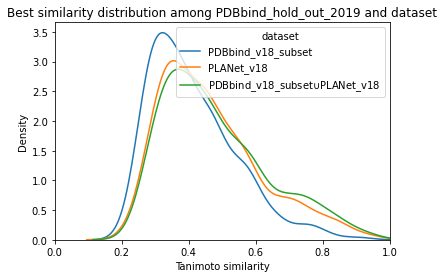

In [80]:
sns.kdeplot(max_simi_distribution['PDBbind_v18_subset'])
sns.kdeplot(max_simi_distribution['PLANet_v18'])
sns.kdeplot(max_simi_distribution['PDBbind_v18_subset_union_PLANet_v18'])
plt.xlabel("Tanimoto similarity")
plt.xlim(0,1)
plt.title(f'Best similarity distribution among PDBbind_hold_out_2019 and dataset') #
plt.legend(labels=['PDBbind_v18_subset', 'PLANet_v18', 'PDBbind_v18_subset' +r'$\cup$' 'PLANet_v18'], title = "dataset")
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/similarity/3_models.png', dpi=300, bbox_inches='tight')
# plt.close()

# 3.2 PLANet_hold_out_2019

In [68]:
PLANet_hold_out_df = pd.read_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/index/minimized/PLANet_hold_out_2019.csv', sep='\t')
PLANet_hold_out_mols, PLANet_hold_out_mol_fps = obtain_training_fps(PLANet_hold_out_df, 'PLANet_hold_out')

In [69]:
len(PLANet_hold_out_df)

5883

In [70]:
len(PLANet_hold_out_mols)

5883

In [71]:
PLANet_hold_out_mol_names = [mol.GetProp('_Name') for mol in PLANet_hold_out_mols]

In [72]:
def calculate_simi(hold_2019_mols, hold_2019_mol_fps, hold_2019_df, mols_2, mol_fps_2, affi_df_2, set_name_1, set_name_2):
    max_simi_for_hold_2019_mols = []
    cols = [f'{set_name_1}_name', f'{set_name_1}_affi', f'{set_name_1}_smiles', f'{set_name_2}_cpnd_name', f'{set_name_2}_cpnd_affi', f'{set_name_2}_cpnd_smiles', 'similarity']
    lst = []
    for i, mol in enumerate(hold_2019_mols):
        simi_list = DataStructs.BulkTanimotoSimilarity(hold_2019_mol_fps[i], mol_fps_2)
        mol_name = mol.GetProp('_Name')
        for j,simi in enumerate(simi_list):
            if simi > 0.8:
                # mol_affi = hold_2019_df[hold_2019_df['pdb_id']==mol_name]['-logAffi'].values[0]
                if 'pdb_id' in hold_2019_df.columns.values:
                    mol_affi = hold_2019_df[hold_2019_df['pdb_id']==mol_name]['-logAffi'].values[0]
                else:
                    mol_affi = hold_2019_df[hold_2019_df['unique_identify']==mol_name]['-logAffi'].values[0]
                mol_smiles = Chem.MolToSmiles(mol)
                mol_2_name = mols_2[j].GetProp('_Name')
                if 'pdb_id' in affi_df_2.columns.values:
                    mol_2_affi = affi_df_2[affi_df_2['pdb_id']==mol_2_name]['-logAffi'].values[0]
                else:
                    mol_2_affi = affi_df_2[affi_df_2['unique_identify']==mol_2_name]['-logAffi'].values[0]
                mol_2_smiles = Chem.MolToSmiles(mols_2[j])
                lst.append([mol_name, mol_affi, mol_smiles, mol_2_name, mol_2_affi, mol_2_smiles, simi])
        max_simi = max(simi_list)
        max_simi_for_hold_2019_mols.append(max_simi)
    out_dir = f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PLANet_hold_out_2019/similarity/{set_name_2}_in_{set_name_1}' #
    if not Path(out_dir).exists():
        Path(out_dir).mkdir(parents=True)
    simi_9_df = pd.DataFrame(lst, columns=cols)
    simi_9_df.to_csv(f'{out_dir}/simi_0.8.csv', sep='\t', index=False)
    print(f'For {set_name_1}, there are {max_simi_for_hold_2019_mols.count(1)} / {len(max_simi_for_hold_2019_mols)} PDB IDs same as(similarity=1, not considering chirality) {set_name_2}.')
    print(f'similarity > 0.8: {len([n for n in max_simi_for_hold_2019_mols if n>0.8])} / {len(max_simi_for_hold_2019_mols)}')
    return max_simi_for_hold_2019_mols

In [73]:
max_simi_for_PLANet_hold_2019_test_PDBbind_v18_subset = calculate_simi(PLANet_hold_out_mols, PLANet_hold_out_mol_fps, PLANet_hold_out_df, PDBbind_v18_subset_mols, PDBbind_v18_subset_mol_fps, PDBbind_v18_subset_df, f'PLANet_hold_out_2019', 'PDBbind_v18_subset')
max_simi_for_PLANet_hold_2019_test_Uw = calculate_simi(PLANet_hold_out_mols, PLANet_hold_out_mol_fps, PLANet_hold_out_df, PLANet_v18_mols, PLANet_v18_mol_fps, PLANet_v18_df, f'PLANet_hold_out_2019', 'PLANet_v18')
max_simi_for_PLANet_hold_2019_test_PIPUP = calculate_simi(PLANet_hold_out_mols, PLANet_hold_out_mol_fps, PLANet_hold_out_df, PIPUP_v18_mols, PIPUP_v18_mol_fps, PIPUP_v18_df, f'PLANet_hold_out_2019', 'PIPUP_v18')

For PLANet_hold_out_2019, there are 0 / 5883 PDB IDs same as(similarity=1, not considering chirality) PDBbind_v18_subset.
similarity > 0.8: 14 / 5883
For PLANet_hold_out_2019, there are 0 / 5883 PDB IDs same as(similarity=1, not considering chirality) PLANet_v18.
similarity > 0.8: 403 / 5883
For PLANet_hold_out_2019, there are 0 / 5883 PDB IDs same as(similarity=1, not considering chirality) PIPUP_v18.
similarity > 0.8: 408 / 5883


In [81]:
max_simi_distribution = pd.DataFrame({"unique_identify": PLANet_hold_out_mol_names, "PDBbind_v18_subset": max_simi_for_PLANet_hold_2019_test_PDBbind_v18_subset, "PLANet_v18": max_simi_for_PLANet_hold_2019_test_Uw, "PDBbind_v18_subset_union_PLANet_v18": max_simi_for_PLANet_hold_2019_test_PIPUP})
max_simi_distribution.to_csv(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PLANet_hold_out_2019/similarity/all_6_models_max_simi_distribution.csv', sep='\t', index=False)

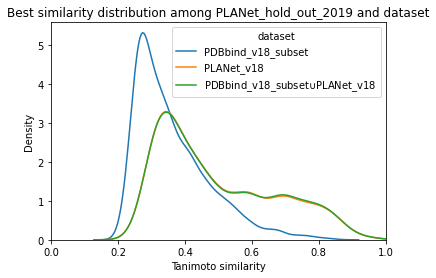

In [82]:
sns.kdeplot(max_simi_distribution['PDBbind_v18_subset'])
sns.kdeplot(max_simi_distribution['PLANet_v18'])
sns.kdeplot(max_simi_distribution['PDBbind_v18_subset_union_PLANet_v18'])
plt.xlabel("Tanimoto similarity")
plt.xlim(0,1)
plt.title(f'Best similarity distribution among PLANet_hold_out_2019 and dataset')
plt.legend(labels=['PDBbind_v18_subset', 'PLANet_v18', 'PDBbind_v18_subset' +r'$\cup$' 'PLANet_v18'], title = "dataset")
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PLANet_hold_out_2019/similarity/3_models.png', dpi=300, bbox_inches='tight')
# plt.close()

# 4. property distribution of PDBbind_hold_out_2019

In [132]:
PDBbind_hold_prop

,pdb_id,-logAffi,mw,logp,rotb,hbd,hba,q,HA
0,6gmx,2.17,198.674,3.0185,0.0,0.0,2.0,0.0,12.0
1,6gmq,2.30,173.215,1.9696,2.0,1.0,2.0,0.0,13.0
2,5ye8,3.00,207.201,1.3363,2.0,1.0,2.0,0.0,13.0
3,6ftz,3.00,309.349,1.2610,4.0,4.0,2.0,1.0,23.0
4,6f6n,3.02,307.244,4.1534,2.0,1.0,0.0,1.0,20.0
...,...,...,...,...,...,...,...,...,...
480,6h5w,10.80,407.537,0.6063,5.0,2.0,6.0,-1.0,27.0
481,6h5x,10.82,407.537,0.6063,5.0,2.0,6.0,-1.0,27.0
482,5nn0,10.96,457.662,1.8888,7.0,2.0,1.0,2.0,34.0
483,5llg,11.13,231.342,1.8361,4.0,1.0,3.0,0.0,14.0


In [133]:
max(PDBbind_hold_prop['-logAffi'])

11.22

In [27]:
PDBbind_hold_prop.reset_index(inplace=True, drop=True)

# MW

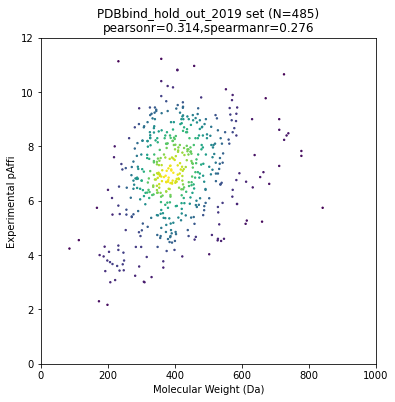

In [134]:
# RIP_minimized_PCV.reset_index(drop=True, inplace=True)
pearsonr = round(stats.pearsonr(PDBbind_hold_prop['mw'], PDBbind_hold_prop['-logAffi'])[0],3)
spearmanr = round(stats.spearmanr(PDBbind_hold_prop['mw'], PDBbind_hold_prop['-logAffi'])[0],3)

xy = np.vstack([PDBbind_hold_prop['mw'], PDBbind_hold_prop['-logAffi']])  #按行叠加
g = gaussian_kde(xy)  #根据xy进行核密度估计(kde) -> 关于xy的概率密度函数
z = g(xy)  #计算每个xy样本点的概率密度

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()  #对z值排序并返回索引
y, y_, z = PDBbind_hold_prop['mw'][idx], PDBbind_hold_prop['-logAffi'][idx], z[idx]  #对y, y_根据z的大小进行排序

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y, y_, s=2, c=z, zorder=2)
ax.set_xlabel('Molecular Weight (Da)')
ax.set_ylabel('Experimental pAffi')
ax.set_xlim(0,1000)
ax.set_ylim(0,12)
plt.title(f'PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})\npearsonr={pearsonr},spearmanr={spearmanr}')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/property_distribution/Mw_pAffi_scaled_1000.png', dpi=300, bbox_inches='tight')

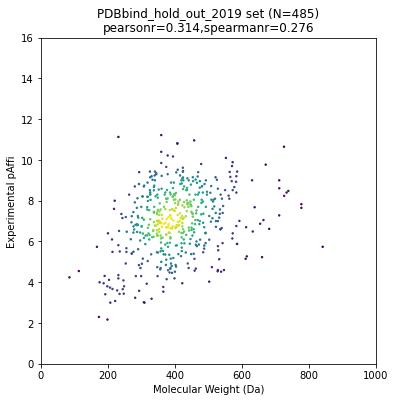

In [189]:
# RIP_minimized_PCV.reset_index(drop=True, inplace=True)
pearsonr = round(stats.pearsonr(PDBbind_hold_prop['mw'], PDBbind_hold_prop['-logAffi'])[0],3)
spearmanr = round(stats.spearmanr(PDBbind_hold_prop['mw'], PDBbind_hold_prop['-logAffi'])[0],3)

xy = np.vstack([PDBbind_hold_prop['mw'], PDBbind_hold_prop['-logAffi']])  #按行叠加
g = gaussian_kde(xy)  #根据xy进行核密度估计(kde) -> 关于xy的概率密度函数
z = g(xy)  #计算每个xy样本点的概率密度

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()  #对z值排序并返回索引
y, y_, z = PDBbind_hold_prop['mw'][idx], PDBbind_hold_prop['-logAffi'][idx], z[idx]  #对y, y_根据z的大小进行排序

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y, y_, s=2, c=z, zorder=2)
ax.set_xlabel('Molecular Weight (Da)')
ax.set_ylabel('Experimental pAffi')
ax.set_xlim(0,1000)
ax.set_ylim(0,16)
plt.title(f'PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})\npearsonr={pearsonr},spearmanr={spearmanr}')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/property_distribution/Mw_pAffi_scaled_1000_16.png', dpi=300, bbox_inches='tight')

# HA

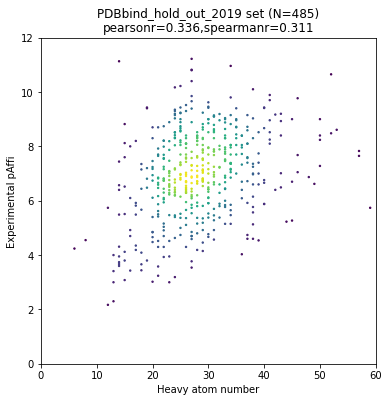

In [135]:
# RIP_minimized_PCV.reset_index(drop=True, inplace=True)
pearsonr = round(stats.pearsonr(PDBbind_hold_prop['HA'], PDBbind_hold_prop['-logAffi'])[0],3)
spearmanr = round(stats.spearmanr(PDBbind_hold_prop['HA'], PDBbind_hold_prop['-logAffi'])[0],3)

xy = np.vstack([PDBbind_hold_prop['HA'], PDBbind_hold_prop['-logAffi']])  #按行叠加
g = gaussian_kde(xy)  #根据xy进行核密度估计(kde) -> 关于xy的概率密度函数
z = g(xy)  #计算每个xy样本点的概率密度

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()  #对z值排序并返回索引
y, y_, z = PDBbind_hold_prop['HA'][idx], PDBbind_hold_prop['-logAffi'][idx], z[idx]  #对y, y_根据z的大小进行排序

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y, y_, s=2, c=z, zorder=2)
ax.set_xlabel('Heavy atom number')
ax.set_ylabel('Experimental pAffi')
ax.set_xlim(0,60)
ax.set_ylim(0,12)
plt.title(f'PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})\npearsonr={pearsonr},spearmanr={spearmanr}')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/property_distribution/HA_pAffi_scaled_1000.png', dpi=300, bbox_inches='tight')

# SASA

In [8]:
PDBbind_hold_prop_sasa = pd.merge(PDBbind_hold_prop, PDBbind_whole_sasa.rename(columns={'unique_identity':'pdb_id'}), on=['pdb_id'])
PDBbind_hold_prop_sasa

,pdb_id,-logAffi,mw,logp,rotb,hbd,hba,q,HA,lig_sasa,rec_sasa,com_sasa,del_sasa
0,6gmx,2.17,198.674,3.0185,0.0,0.0,2.0,0.0,12.0,3.584276,169.899353,169.134735,4.348892
1,6gmq,2.30,173.215,1.9696,2.0,1.0,2.0,0.0,13.0,3.836170,170.113678,169.312775,4.637070
2,5ye8,3.00,207.201,1.3363,2.0,1.0,2.0,0.0,13.0,3.664690,154.229050,153.094147,4.799591
3,6ftz,3.00,309.349,1.2610,4.0,4.0,2.0,1.0,23.0,5.669580,105.767990,104.908936,6.528633
4,6f6n,3.02,307.244,4.1534,2.0,1.0,0.0,1.0,20.0,5.262110,215.081009,213.202118,7.141006
...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,6h5w,10.80,407.537,0.6063,5.0,2.0,6.0,-1.0,27.0,6.242145,233.620682,231.630371,8.232452
481,6h5x,10.82,407.537,0.6063,5.0,2.0,6.0,-1.0,27.0,6.278202,235.834656,233.930405,8.182449
482,5nn0,10.96,457.662,1.8888,7.0,2.0,1.0,2.0,34.0,8.044558,206.258041,208.660782,5.641815
483,5llg,11.13,231.342,1.8361,4.0,1.0,3.0,0.0,14.0,4.416166,117.344330,116.403198,5.357300


In [9]:
max(PDBbind_hold_prop_sasa['del_sasa'])

15.08477783203125

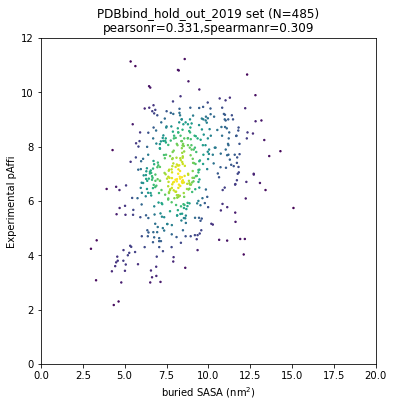

In [31]:
# RIP_minimized_PCV.reset_index(drop=True, inplace=True)
pearsonr = round(stats.pearsonr(PDBbind_hold_prop_sasa['del_sasa'], PDBbind_hold_prop_sasa['-logAffi'])[0],3)
spearmanr = round(stats.spearmanr(PDBbind_hold_prop_sasa['del_sasa'], PDBbind_hold_prop_sasa['-logAffi'])[0],3)

xy = np.vstack([PDBbind_hold_prop_sasa['del_sasa'], PDBbind_hold_prop_sasa['-logAffi']])  #按行叠加
g = gaussian_kde(xy)  #根据xy进行核密度估计(kde) -> 关于xy的概率密度函数
z = g(xy)  #计算每个xy样本点的概率密度

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()  #对z值排序并返回索引
y, y_, z = PDBbind_hold_prop_sasa['del_sasa'][idx], PDBbind_hold_prop_sasa['-logAffi'][idx], z[idx]  #对y, y_根据z的大小进行排序

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y, y_, s=2, c=z, zorder=2)
ax.set_xlabel('buried SASA (nm$\mathregular{^2}$)')
ax.set_ylabel('Experimental pAffi')
ax.set_xlim(0, 20)
ax.set_ylim(0,12)
plt.title(f'PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop_sasa)})\npearsonr={pearsonr},spearmanr={spearmanr}')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/property_distribution/SASA_pAffi_scaled_1000.png', dpi=300, bbox_inches='tight')

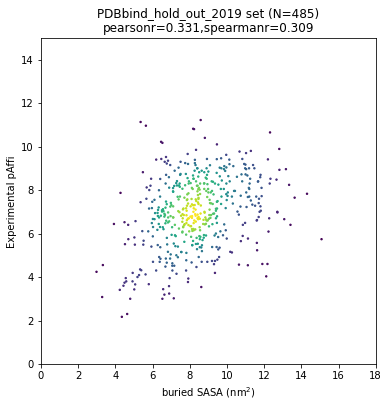

In [13]:
# RIP_minimized_PCV.reset_index(drop=True, inplace=True)
pearsonr = round(stats.pearsonr(PDBbind_hold_prop_sasa['del_sasa'], PDBbind_hold_prop_sasa['-logAffi'])[0],3)
spearmanr = round(stats.spearmanr(PDBbind_hold_prop_sasa['del_sasa'], PDBbind_hold_prop_sasa['-logAffi'])[0],3)

xy = np.vstack([PDBbind_hold_prop_sasa['del_sasa'], PDBbind_hold_prop_sasa['-logAffi']])  #按行叠加
g = gaussian_kde(xy)  #根据xy进行核密度估计(kde) -> 关于xy的概率密度函数
z = g(xy)  #计算每个xy样本点的概率密度

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()  #对z值排序并返回索引
y, y_, z = PDBbind_hold_prop_sasa['del_sasa'][idx], PDBbind_hold_prop_sasa['-logAffi'][idx], z[idx]  #对y, y_根据z的大小进行排序

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y, y_, s=2, c=z, zorder=2)
ax.set_xlabel('buried SASA (nm$\mathregular{^2}$)')
ax.set_ylabel('Experimental pAffi')
ax.set_xlim(0, 18)
ax.set_ylim(0,15)
plt.title(f'PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop_sasa)})\npearsonr={pearsonr},spearmanr={spearmanr}')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/property_distribution/SASA_pAffi_scaled_18.png', dpi=300, bbox_inches='tight')

# logp

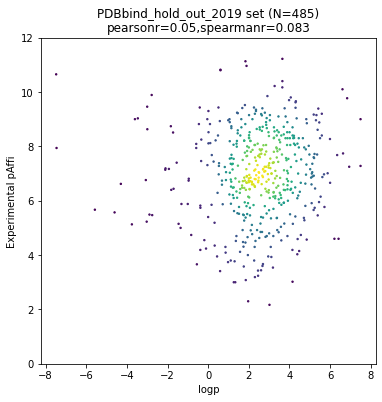

In [35]:
# RIP_minimized_PCV.reset_index(drop=True, inplace=True)
pearsonr = round(stats.pearsonr(PDBbind_hold_prop_sasa['logp'], PDBbind_hold_prop_sasa['-logAffi'])[0],3)
spearmanr = round(stats.spearmanr(PDBbind_hold_prop_sasa['logp'], PDBbind_hold_prop_sasa['-logAffi'])[0],3)

xy = np.vstack([PDBbind_hold_prop_sasa['logp'], PDBbind_hold_prop_sasa['-logAffi']])  #按行叠加
g = gaussian_kde(xy)  #根据xy进行核密度估计(kde) -> 关于xy的概率密度函数
z = g(xy)  #计算每个xy样本点的概率密度

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()  #对z值排序并返回索引
y, y_, z = PDBbind_hold_prop_sasa['logp'][idx], PDBbind_hold_prop_sasa['-logAffi'][idx], z[idx]  #对y, y_根据z的大小进行排序

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y, y_, s=2, c=z, zorder=2)
ax.set_xlabel('logp')
ax.set_ylabel('Experimental pAffi')
# ax.set_xlim(0, 20)
ax.set_ylim(0,12)
plt.title(f'PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop_sasa)})\npearsonr={pearsonr},spearmanr={spearmanr}')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/property_distribution/logp_pAffi_scaled_1000.png', dpi=300, bbox_inches='tight')

# 5. pfam

In [36]:
PDBbind_hold_prop_sasa

,pdb_id,-logAffi,mw,logp,rotb,hbd,hba,q,HA,lig_sasa,rec_sasa,com_sasa,del_sasa
0,6gmx,2.17,198.674,3.0185,0.0,0.0,2.0,0.0,12.0,3.584276,169.899353,169.134735,4.348892
1,6gmq,2.30,173.215,1.9696,2.0,1.0,2.0,0.0,13.0,3.836170,170.113678,169.312775,4.637070
2,5ye8,3.00,207.201,1.3363,2.0,1.0,2.0,0.0,13.0,3.664690,154.229050,153.094147,4.799591
3,6ftz,3.00,309.349,1.2610,4.0,4.0,2.0,1.0,23.0,5.669580,105.767990,104.908936,6.528633
4,6f6n,3.02,307.244,4.1534,2.0,1.0,0.0,1.0,20.0,5.262110,215.081009,213.202118,7.141006
...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,6h5w,10.80,407.537,0.6063,5.0,2.0,6.0,-1.0,27.0,6.242145,233.620682,231.630371,8.232452
481,6h5x,10.82,407.537,0.6063,5.0,2.0,6.0,-1.0,27.0,6.278202,235.834656,233.930405,8.182449
482,5nn0,10.96,457.662,1.8888,7.0,2.0,1.0,2.0,34.0,8.044558,206.258041,208.660782,5.641815
483,5llg,11.13,231.342,1.8361,4.0,1.0,3.0,0.0,14.0,4.416166,117.344330,116.403198,5.357300


In [37]:
PDBbind_v2020_cluster = pd.read_csv('/pubhome/xli02/scripts/scripts_from_zhuhui/general_refine_classified.csv')
PDBbind_v2020_cluster_sel = PDBbind_v2020_cluster[['pdb', 'PCV_cluster']].copy()
PDBbind_v2020_cluster_sel.rename(columns={'pdb':'pdb_id'}, inplace=True)
PDBbind_v2020_cluster_sel

,pdb_id,PCV_cluster
0,4i7p,Lysozyme
1,1l83,Lysozyme
2,1li6,Lysozyme
3,4w52,Lysozyme
4,188l,Lysozyme
...,...,...
19434,5ylv,una_223
19435,3ump,Ribokinase
19436,4q3r,Arginase
19437,1ind,Ig


In [38]:
PDBbind_hold_prop_sasa_Pfam = pd.merge(PDBbind_hold_prop_sasa, PDBbind_v2020_cluster_sel, on='pdb_id')
PDBbind_hold_prop_sasa_Pfam

,pdb_id,-logAffi,mw,logp,rotb,hbd,hba,q,HA,lig_sasa,rec_sasa,com_sasa,del_sasa,PCV_cluster
0,6gmx,2.17,198.674,3.0185,0.0,0.0,2.0,0.0,12.0,3.584276,169.899353,169.134735,4.348892,una_579
1,6gmq,2.30,173.215,1.9696,2.0,1.0,2.0,0.0,13.0,3.836170,170.113678,169.312775,4.637070,Transthyretin
2,5ye8,3.00,207.201,1.3363,2.0,1.0,2.0,0.0,13.0,3.664690,154.229050,153.094147,4.799591,AB_hydrolase
3,6ftz,3.00,309.349,1.2610,4.0,4.0,2.0,1.0,23.0,5.669580,105.767990,104.908936,6.528633,Peptidase_PA
4,6f6n,3.02,307.244,4.1534,2.0,1.0,0.0,1.0,20.0,5.262110,215.081009,213.202118,7.141006,una_204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,6h5w,10.80,407.537,0.6063,5.0,2.0,6.0,-1.0,27.0,6.242145,233.620682,231.630371,8.232452,Peptidase_MA
481,6h5x,10.82,407.537,0.6063,5.0,2.0,6.0,-1.0,27.0,6.278202,235.834656,233.930405,8.182449,Peptidase_MA
482,5nn0,10.96,457.662,1.8888,7.0,2.0,1.0,2.0,34.0,8.044558,206.258041,208.660782,5.641815,AB_hydrolase
483,5llg,11.13,231.342,1.8361,4.0,1.0,3.0,0.0,14.0,4.416166,117.344330,116.403198,5.357300,Carb_anhydrase


In [188]:
PDBbind_hold_prop_sasa_Pfam.to_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/property_distribution/PDBbind_hold_out_2019_property.csv', sep='\t', index=False)

In [4]:
PDBbind_hold_prop_sasa_Pfam = pd.read_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/property_distribution/PDBbind_hold_out_2019_property.csv', sep='\t')
len(PDBbind_hold_prop_sasa_Pfam)

485

In [39]:
len(set(PDBbind_hold_prop_sasa_Pfam['PCV_cluster']))

72

In [40]:
PCV_count_df = pd.DataFrame({'count':PDBbind_hold_prop_sasa_Pfam.groupby('PCV_cluster').size()}).reset_index()
PCV_count_df.sort_values(by='count', ascending=False).head(10)

,PCV_cluster,count
61,pkinase,116
15,Carb_anhydrase,36
11,Bromodomain,35
60,hormone_recep,21
28,His_Kinase_A,19
27,HD_PDEase,17
23,GPCR_A,15
48,Peptidase_PA,15
5,Arginase,14
0,AB_hydrolase,11


In [118]:
PCV_count_df[PCV_count_df['count']>10]

,PCV_cluster,count
0,AB_hydrolase,11
5,Arginase,14
11,Bromodomain,35
15,Carb_anhydrase,36
23,GPCR_A,15
27,HD_PDEase,17
28,His_Kinase_A,19
46,Peptidase_MA,11
48,Peptidase_PA,15
60,hormone_recep,21


In [45]:
PCV_count_df[PCV_count_df['PCV_cluster']=='hormone_recep']

,PCV_cluster,count
60,hormone_recep,21


In [41]:
top10_clusters=list(PCV_count_df.sort_values(by='count', ascending=False).head(10)['PCV_cluster'])
top10_clusters

['pkinase',
 'Carb_anhydrase',
 'Bromodomain',
 'hormone_recep',
 'His_Kinase_A',
 'HD_PDEase',
 'GPCR_A',
 'Peptidase_PA',
 'Arginase',
 'AB_hydrolase']

In [42]:
pfam_label_to_res_dict = defaultdict(list)
for model in models:
    for tp in tps:
        res_df = pd.read_csv(f'{test_dir}/test_on_PDBbind_hold_out_2019/{model}_{tp}/test.csv', sep='\t')
        res_df_with_PCV = pd.merge(res_df, PDBbind_v2020_cluster_sel.rename(columns={'pdb_id':'unique_identify'}), on='unique_identify')
        for cluster in top10_clusters:
            hold_out_cluster = res_df_with_PCV[res_df_with_PCV['PCV_cluster']==cluster].copy()
            for i in range(5):
                r2 = r2_score(y_true=hold_out_cluster['y_true'], y_pred=hold_out_cluster[f'{model}_{tp}_{i+1}_pred'])
                mae = mean_absolute_error(y_true=hold_out_cluster['y_true'], y_pred=hold_out_cluster[f'{model}_{tp}_{i+1}_pred'])
                mse = mean_squared_error(y_true=hold_out_cluster['y_true'], y_pred=hold_out_cluster[f'{model}_{tp}_{i+1}_pred'])
                pearsonr = stats.pearsonr(hold_out_cluster['y_true'], hold_out_cluster[f'{model}_{tp}_{i+1}_pred'])[0]
                spearmanr = stats.spearmanr(hold_out_cluster['y_true'], hold_out_cluster[f'{model}_{tp}_{i+1}_pred'])[0]
                pfam_label_to_res_dict[f'{model}_{tp}_{i+1}_cluster_{cluster}']=[r2, mae, mse, pearsonr, spearmanr]
        cluster='others'
        hold_out_cluster = res_df_with_PCV[~res_df_with_PCV['PCV_cluster'].isin(top10_clusters)].copy()
        for i in range(5):
            r2 = r2_score(y_true=hold_out_cluster['y_true'], y_pred=hold_out_cluster[f'{model}_{tp}_{i+1}_pred'])
            mae = mean_absolute_error(y_true=hold_out_cluster['y_true'], y_pred=hold_out_cluster[f'{model}_{tp}_{i+1}_pred'])
            mse = mean_squared_error(y_true=hold_out_cluster['y_true'], y_pred=hold_out_cluster[f'{model}_{tp}_{i+1}_pred'])
            pearsonr = stats.pearsonr(hold_out_cluster['y_true'], hold_out_cluster[f'{model}_{tp}_{i+1}_pred'])[0]
            spearmanr = stats.spearmanr(hold_out_cluster['y_true'], hold_out_cluster[f'{model}_{tp}_{i+1}_pred'])[0]
            pfam_label_to_res_dict[f'{model}_{tp}_{i+1}_cluster_{cluster}']=[r2, mae, mse, pearsonr, spearmanr]

In [44]:
pfam_sum_df = pd.DataFrame.from_dict(pfam_label_to_res_dict, orient='index', columns=['r2', 'mae', 'mse', 'pearsonr', 'spearmanr']).reset_index()
pfam_sum_df['rmse']= np.sqrt(pfam_sum_df['mse'])
pfam_sum_df.rename(columns={"index": "model_names_test_type_cluster"}, inplace=True)
pfam_sum_df['cluster'] = pfam_sum_df['model_names_test_type_cluster'].str.rsplit('cluster_', n=1).str[1]
pfam_sum_df['model_names_test_type'] = pfam_sum_df['model_names_test_type_cluster'].str.rsplit('_cluster', n=1).str[0]
pfam_sum_df['model_tp'] = pfam_sum_df['model_names_test_type'].str.rsplit('_', n=1).str[0]
pfam_sum_df['type'] = ['cmx' if 'cmx' in m else 'ligand_alone' for m in pfam_sum_df['model_tp']]
pfam_sum_df['dataset'] = ['_'.join(m.split('_')[:-1]) if 'cmx' in m else '_'.join(m.split('_')[:-2]) for m in pfam_sum_df['model_tp']]
pfam_sum_df.to_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/pfam_cluster/6_models_5_repeats_metrics.csv', sep='\t', index=False)
pfam_sum_df

,model_names_test_type_cluster,r2,mae,mse,pearsonr,spearmanr,rmse,cluster,model_names_test_type,model_tp,type,dataset
0,PDBbind_minimized_v18_subset_cmx_1_cluster_pki...,0.213595,0.981581,1.502326,0.501327,0.423519,1.225694,pkinase,PDBbind_minimized_v18_subset_cmx_1,PDBbind_minimized_v18_subset_cmx,cmx,PDBbind_minimized_v18_subset
1,PDBbind_minimized_v18_subset_cmx_2_cluster_pki...,0.247519,0.972103,1.437519,0.523177,0.380736,1.198966,pkinase,PDBbind_minimized_v18_subset_cmx_2,PDBbind_minimized_v18_subset_cmx,cmx,PDBbind_minimized_v18_subset
2,PDBbind_minimized_v18_subset_cmx_3_cluster_pki...,0.114500,1.064856,1.691634,0.432308,0.285028,1.300628,pkinase,PDBbind_minimized_v18_subset_cmx_3,PDBbind_minimized_v18_subset_cmx,cmx,PDBbind_minimized_v18_subset
3,PDBbind_minimized_v18_subset_cmx_4_cluster_pki...,0.305843,0.928469,1.326098,0.572684,0.500454,1.151563,pkinase,PDBbind_minimized_v18_subset_cmx_4,PDBbind_minimized_v18_subset_cmx,cmx,PDBbind_minimized_v18_subset
4,PDBbind_minimized_v18_subset_cmx_5_cluster_pki...,0.187774,0.994805,1.551654,0.504192,0.381474,1.245654,pkinase,PDBbind_minimized_v18_subset_cmx_5,PDBbind_minimized_v18_subset_cmx,cmx,PDBbind_minimized_v18_subset
...,...,...,...,...,...,...,...,...,...,...,...,...
325,PDBbind_minimized_v18_subset_union_PLANet_v18_...,0.113131,1.230539,2.566486,0.453189,0.443178,1.602026,others,PDBbind_minimized_v18_subset_union_PLANet_v18_...,PDBbind_minimized_v18_subset_union_PLANet_v18_...,ligand_alone,PDBbind_minimized_v18_subset_union_PLANet_v18
326,PDBbind_minimized_v18_subset_union_PLANet_v18_...,0.083076,1.245885,2.653464,0.457419,0.409010,1.628946,others,PDBbind_minimized_v18_subset_union_PLANet_v18_...,PDBbind_minimized_v18_subset_union_PLANet_v18_...,ligand_alone,PDBbind_minimized_v18_subset_union_PLANet_v18
327,PDBbind_minimized_v18_subset_union_PLANet_v18_...,0.127829,1.261400,2.523953,0.454973,0.427107,1.588695,others,PDBbind_minimized_v18_subset_union_PLANet_v18_...,PDBbind_minimized_v18_subset_union_PLANet_v18_...,ligand_alone,PDBbind_minimized_v18_subset_union_PLANet_v18
328,PDBbind_minimized_v18_subset_union_PLANet_v18_...,0.096744,1.243326,2.613908,0.450681,0.419446,1.616759,others,PDBbind_minimized_v18_subset_union_PLANet_v18_...,PDBbind_minimized_v18_subset_union_PLANet_v18_...,ligand_alone,PDBbind_minimized_v18_subset_union_PLANet_v18


In [46]:
cluster_11_count = {}
for cluster in top10_clusters+['others']:
    if cluster != 'others':
        cluster_11_count[cluster]=PCV_count_df[PCV_count_df['PCV_cluster']==cluster]['count'].values[0]
    else:
        cluster_11_count[cluster]=187 #
cluster_11_count['hormone_recep']=20
cluster_11_count


{'pkinase': 116,
 'Carb_anhydrase': 36,
 'Bromodomain': 35,
 'hormone_recep': 20,
 'His_Kinase_A': 19,
 'HD_PDEase': 17,
 'GPCR_A': 15,
 'Peptidase_PA': 15,
 'Arginase': 14,
 'AB_hydrolase': 11,
 'others': 187}

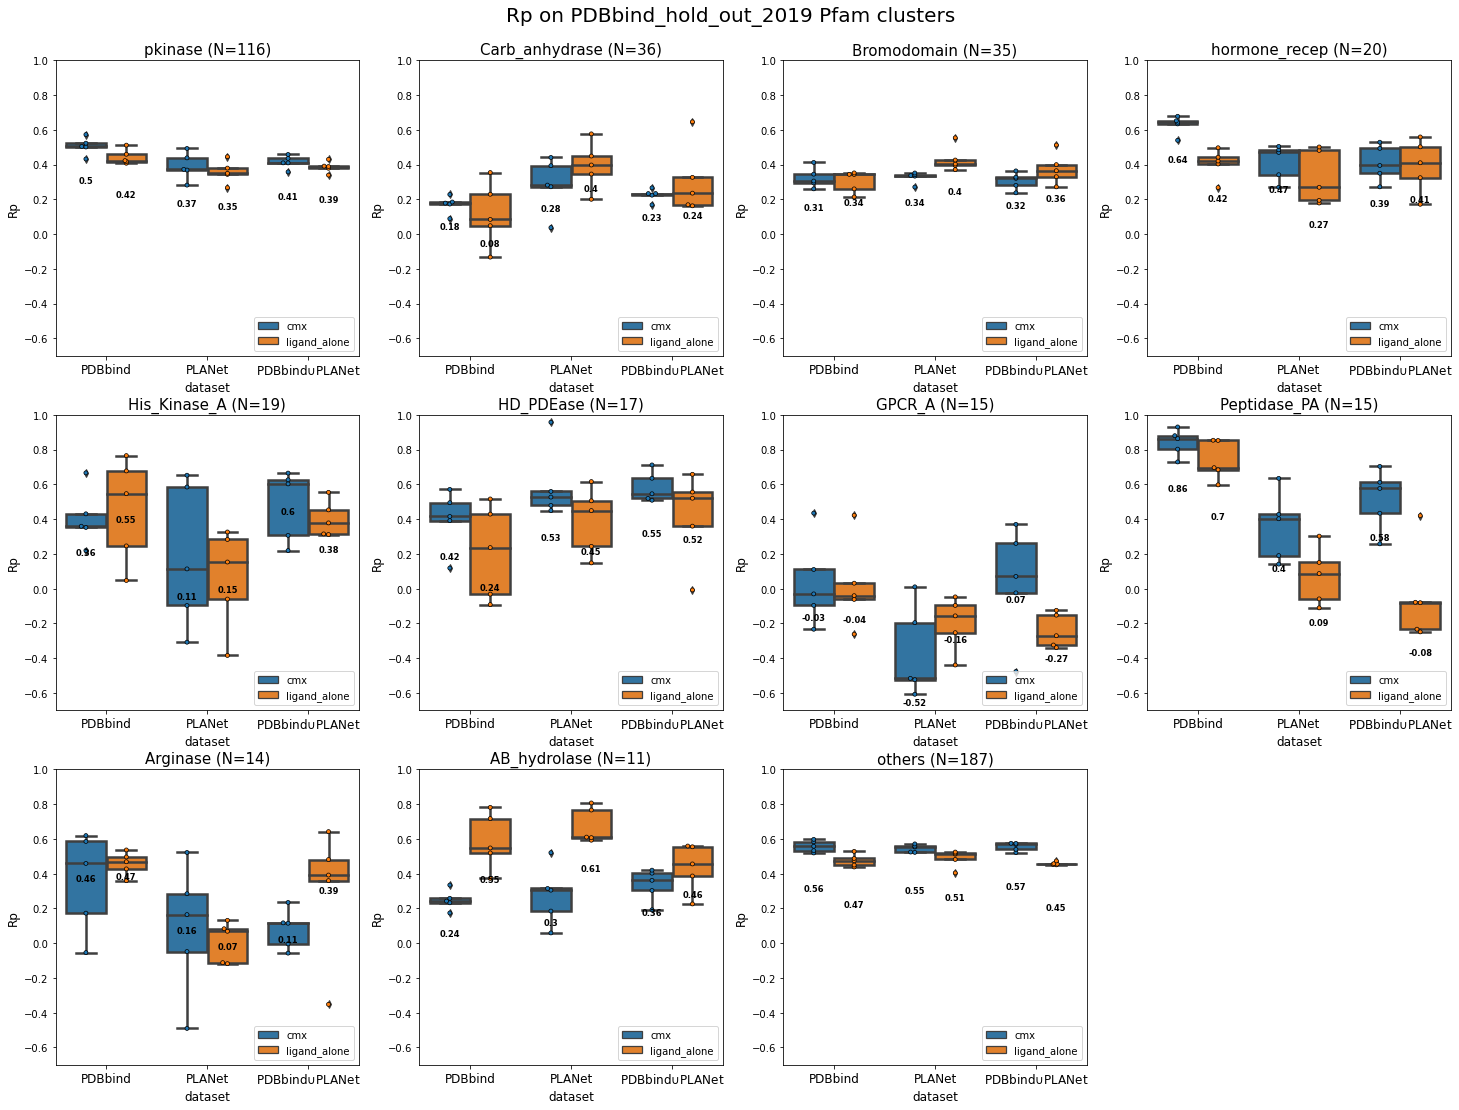

In [55]:
metric='pearsonr'
fig = plt.figure(figsize=(25,25))
for i, cluster in enumerate(top10_clusters+['others']):
    cluster_sum_df = pfam_sum_df[pfam_sum_df['cluster']==cluster]
    grouped_median_cluster = cluster_sum_df.groupby(['dataset', 'type']).median().reset_index()
    grouped_median_cluster['model_name'] = [f'{row.dataset}_{row.type}' for row in grouped_median_cluster.itertuples()]
    
    ax = fig.add_subplot(4, 4, i+1)
    sns.boxplot(x="dataset", y=metric, data=cluster_sum_df, hue="type", order = models, linewidth=2.5)
    sns.swarmplot(x="dataset", y=metric, data=cluster_sum_df, hue="type", order = models, size = 4, dodge=True, edgecolor="black", linewidth=0.7)

    ax.set_title(f'{cluster} (N={cluster_11_count[cluster]})', fontsize=15)
    # fig.autofmt_xdate()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], loc='lower right')
    vertical_offset = cluster_sum_df[metric].median() * 0.5 # offset from median for display
    for i, modl in enumerate(models):
        for tp in ['cmx', 'ligand_alone']:
            median_metric = round(grouped_median_cluster.loc[(grouped_median_cluster['model_name'] == f'{modl}_{tp}')][metric].values[0], 2)
            if cluster in ['Carb_anhydrase', 'GPCR_A']:
                if tp == 'cmx':
                    ax.text(i-.2, median_metric-0.15, median_metric, horizontalalignment='center',size='small', weight='semibold')
                else:
                    ax.text(i+.2, median_metric-0.15, median_metric, horizontalalignment='center',size='small',weight='semibold')
            elif cluster=='Peptidase_PA':
                if tp == 'cmx':
                    ax.text(i-.2, median_metric-0.3, median_metric, horizontalalignment='center',size='small', weight='semibold')
                else:
                    ax.text(i+.2, median_metric-0.3, median_metric, horizontalalignment='center',size='small',weight='semibold')
            else:
                if tp == 'cmx':
                    ax.text(i-.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
                else:
                    ax.text(i+.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
    ax.set_ylim(-0.7,1)
    ax.set_xticklabels(['PDBbind', 'PLANet', 'PDBbind'+r'$\cup{}$' + 'PLANet'], fontsize=12)
    ax.set_ylabel('Rp', fontsize=12)
    ax.set_xlabel('dataset', fontsize=12)
plt.suptitle('Rp on PDBbind_hold_out_2019 Pfam clusters', y=0.91, fontsize=20)
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/pfam_cluster/top10_clusters_{metric}_mean_of_5_repeat_models.png', dpi=300, bbox_inches='tight')
# plt.close()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PDBbind_minimized_v18_subset_ligand_alone vs. PLANet_v18_ligand_alone: t-test independent samples, P_val:3.643e-02 t=2.509e+00
PDBbind_minimized_v18_subset_cmx vs. PLANet_v18_cmx: t-test independent samples, P_val:2.519e-02 t=2.747e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PDBbind_minimized_v18_subset_ligand_alone vs. PLANet_v18_ligand_alone: t-test independent samples, P_val:2.773e-02 t=-2.685e+00
PDBbind_minimized_v18_subset_cmx vs. PLANet_v18_cmx: t-test independent samples, P_val:1.573e-01 t=-1.561e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****

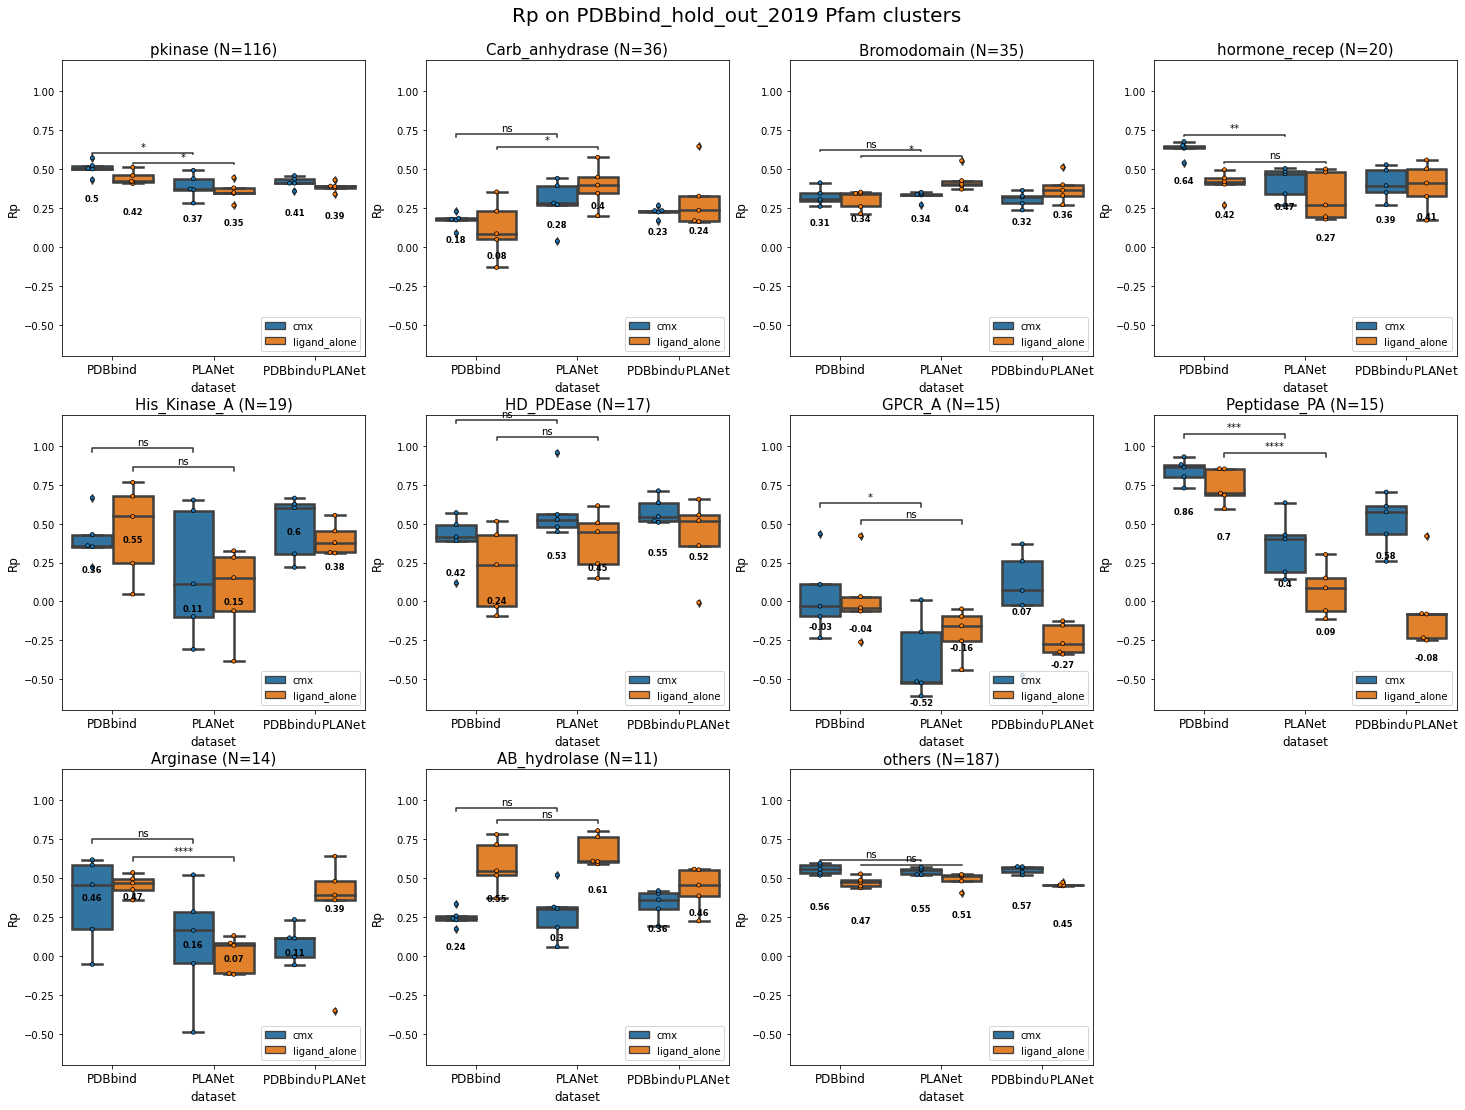

In [183]:
metric='pearsonr'
fig = plt.figure(figsize=(25,25))
for i, cluster in enumerate(top10_clusters+['others']):
    cluster_sum_df = pfam_sum_df[pfam_sum_df['cluster']==cluster]
    grouped_median_cluster = cluster_sum_df.groupby(['dataset', 'type']).median().reset_index()
    grouped_median_cluster['model_name'] = [f'{row.dataset}_{row.type}' for row in grouped_median_cluster.itertuples()]
    
    ax = fig.add_subplot(4, 4, i+1)
    sns.boxplot(x="dataset", y=metric, data=cluster_sum_df, hue="type", order = models, linewidth=2.5)
    sns.swarmplot(x="dataset", y=metric, data=cluster_sum_df, hue="type", order = models, size = 4, dodge=True, edgecolor="black", linewidth=0.7)

    ax.set_title(f'{cluster} (N={cluster_11_count[cluster]})', fontsize=15)

    pairs = [(("PLANet_v18", "ligand_alone"), ("PDBbind_minimized_v18_subset", "ligand_alone")), 
        (("PLANet_v18", "cmx"), ("PDBbind_minimized_v18_subset", "cmx")), 
        ]
    annotator = Annotator(ax, pairs, x="dataset", y=metric, data=cluster_sum_df, hue="type", order = models)
    annotator.configure(test='t-test_ind').apply_and_annotate()

    # fig.autofmt_xdate()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], loc='lower right')
    vertical_offset = cluster_sum_df[metric].median() * 0.5 # offset from median for display
    for i, modl in enumerate(models):
        for tp in ['cmx', 'ligand_alone']:
            median_metric = round(grouped_median_cluster.loc[(grouped_median_cluster['model_name'] == f'{modl}_{tp}')][metric].values[0], 2)
            if cluster in ['Carb_anhydrase', 'GPCR_A']:
                if tp == 'cmx':
                    ax.text(i-.2, median_metric-0.15, median_metric, horizontalalignment='center',size='small', weight='semibold')
                else:
                    ax.text(i+.2, median_metric-0.15, median_metric, horizontalalignment='center',size='small',weight='semibold')
            elif cluster=='Peptidase_PA':
                if tp == 'cmx':
                    ax.text(i-.2, median_metric-0.3, median_metric, horizontalalignment='center',size='small', weight='semibold')
                else:
                    ax.text(i+.2, median_metric-0.3, median_metric, horizontalalignment='center',size='small',weight='semibold')
            else:
                if tp == 'cmx':
                    ax.text(i-.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
                else:
                    ax.text(i+.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
    ax.set_ylim(-0.7,1.2)
    ax.set_xticklabels(['PDBbind', 'PLANet', 'PDBbind'+r'$\cup{}$' + 'PLANet'], fontsize=12)
    ax.set_ylabel('Rp', fontsize=12)
    ax.set_xlabel('dataset', fontsize=12)
plt.suptitle('Rp on PDBbind_hold_out_2019 Pfam clusters', y=0.91, fontsize=20)
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/pfam_cluster/top10_clusters_{metric}_mean_of_5_repeat_models_with_sig.png', dpi=300, bbox_inches='tight')
# plt.close()

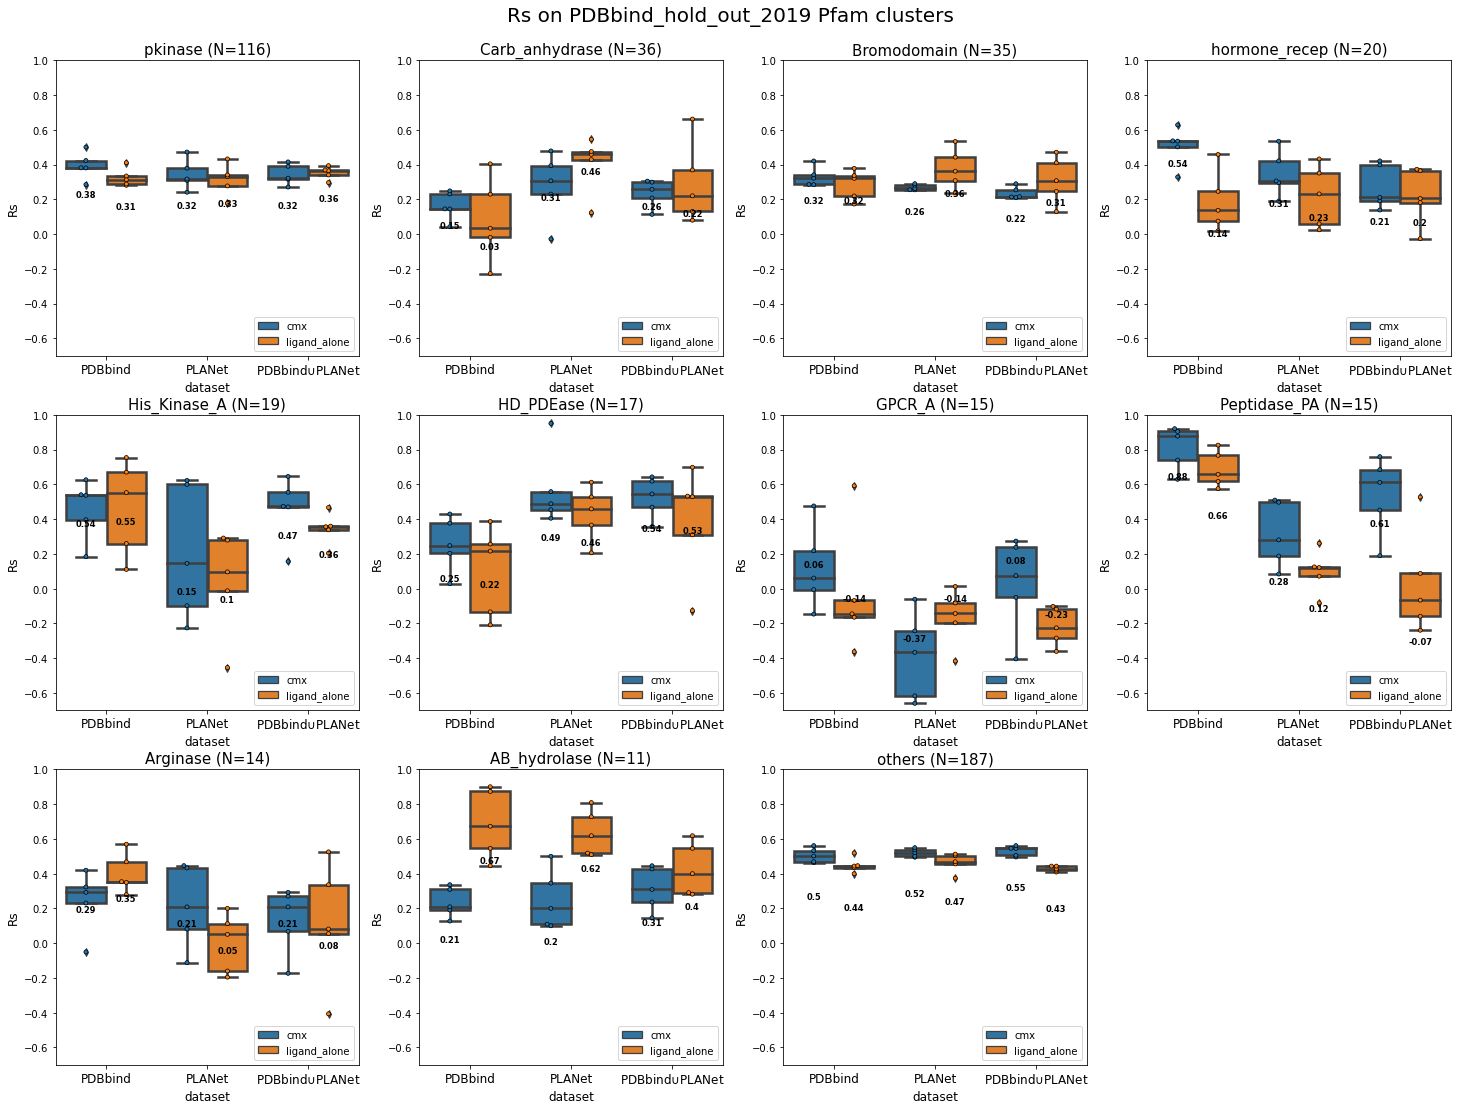

In [59]:
metric='spearmanr'
fig = plt.figure(figsize=(25,25))
for i, cluster in enumerate(top10_clusters+['others']):
    cluster_sum_df = pfam_sum_df[pfam_sum_df['cluster']==cluster]
    grouped_median_cluster = cluster_sum_df.groupby(['dataset', 'type']).median().reset_index()
    grouped_median_cluster['model_name'] = [f'{row.dataset}_{row.type}' for row in grouped_median_cluster.itertuples()]
    
    ax = fig.add_subplot(4, 4, i+1)
    sns.boxplot(x="dataset", y=metric, data=cluster_sum_df, hue="type", order = models, linewidth=2.5)
    sns.swarmplot(x="dataset", y=metric, data=cluster_sum_df, hue="type", order = models, size = 4, dodge=True, edgecolor="black", linewidth=0.7)

    ax.set_title(f'{cluster} (N={cluster_11_count[cluster]})', fontsize=15)
    # fig.autofmt_xdate()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], loc='lower right')
    vertical_offset = cluster_sum_df[metric].median() * 0.5 # offset from median for display
    for i, modl in enumerate(models):
        for tp in ['cmx', 'ligand_alone']:
            median_metric = round(grouped_median_cluster.loc[(grouped_median_cluster['model_name'] == f'{modl}_{tp}')][metric].values[0], 2)
            # if cluster=='PBP':
            #     if tp == 'cmx':
            #         ax.text(i-.2, median_metric-0.15, median_metric, horizontalalignment='center',size='small', weight='semibold')
            #     else:
            #         ax.text(i+.2, median_metric-0.15, median_metric, horizontalalignment='center',size='small',weight='semibold')
            # else:
            if tp == 'cmx':
                ax.text(i-.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
            else:
                ax.text(i+.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
    ax.set_ylim(-0.7,1)
    ax.set_xticklabels(['PDBbind', 'PLANet', 'PDBbind'+r'$\cup{}$' + 'PLANet'], fontsize=12)
    ax.set_ylabel('Rs', fontsize=12)
    ax.set_xlabel('dataset', fontsize=12)
plt.suptitle('Rs on PDBbind_hold_out_2019 Pfam clusters', y=0.91, fontsize=20)
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/pfam_cluster/top10_clusters_{metric}_mean_of_5_repeat_models.png', dpi=300, bbox_inches='tight')
# plt.close()

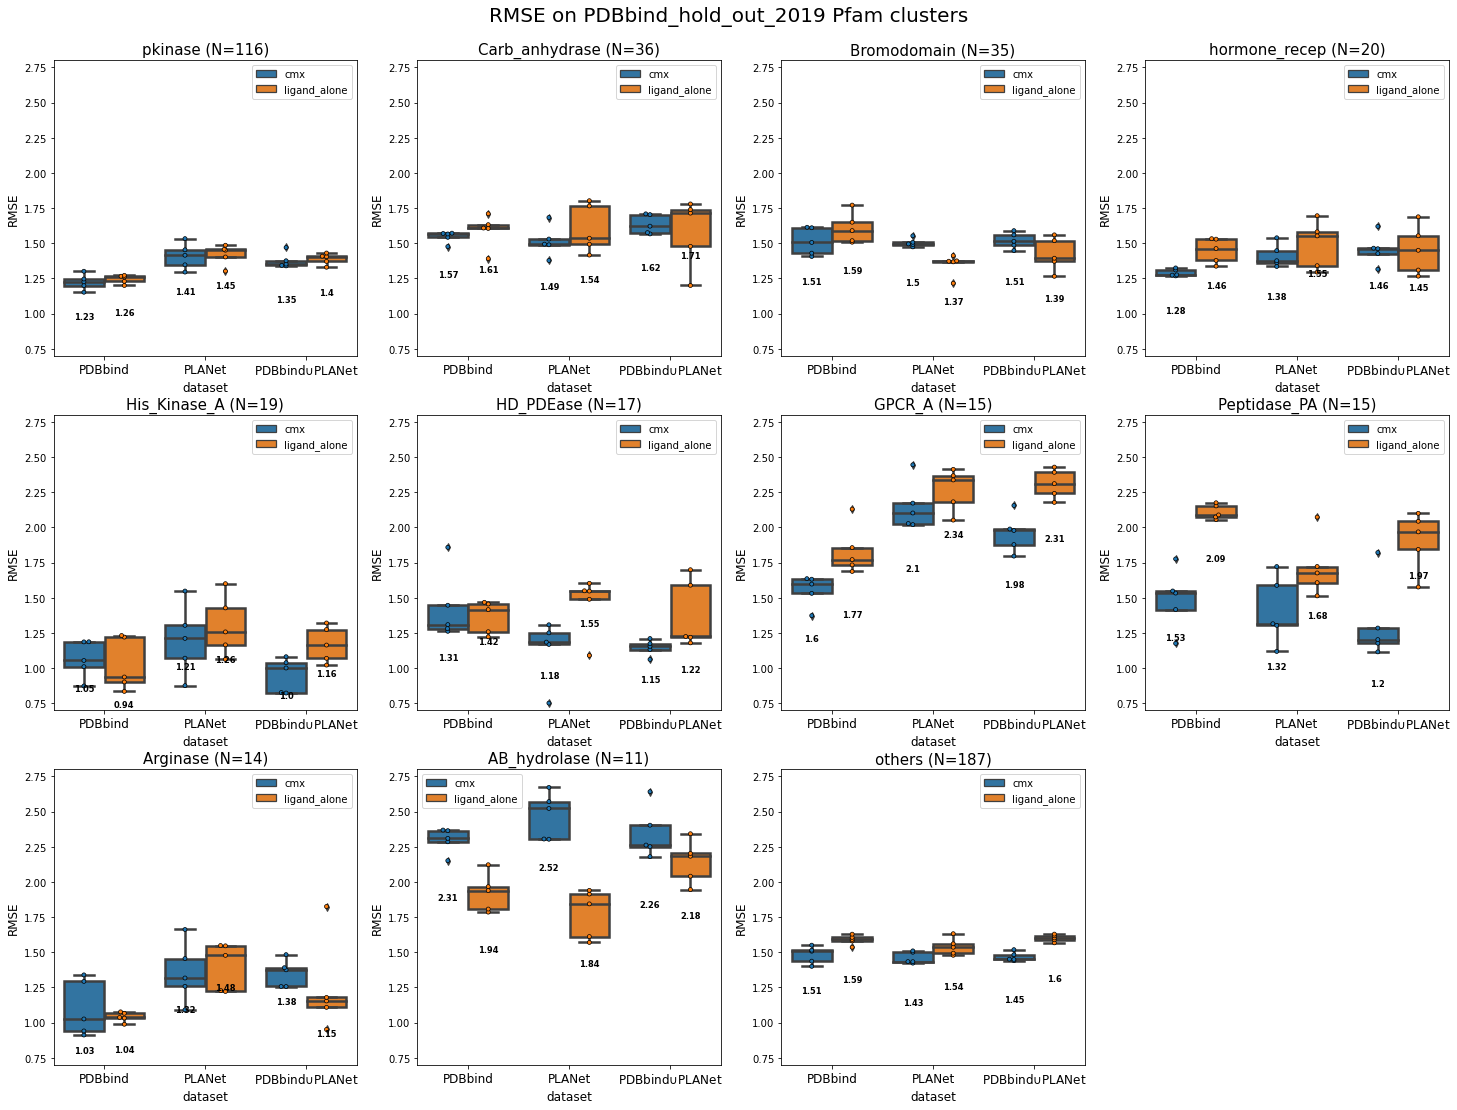

In [62]:
metric='rmse'
fig = plt.figure(figsize=(25,25))
for i, cluster in enumerate(top10_clusters+['others']):
    cluster_sum_df = pfam_sum_df[pfam_sum_df['cluster']==cluster]
    grouped_median_cluster = cluster_sum_df.groupby(['dataset', 'type']).median().reset_index()
    grouped_median_cluster['model_name'] = [f'{row.dataset}_{row.type}' for row in grouped_median_cluster.itertuples()]
    
    ax = fig.add_subplot(4, 4, i+1)
    sns.boxplot(x="dataset", y=metric, data=cluster_sum_df, hue="type", order = models, linewidth=2.5)
    sns.swarmplot(x="dataset", y=metric, data=cluster_sum_df, hue="type", order = models, size = 4, dodge=True, edgecolor="black", linewidth=0.7)

    ax.set_title(f'{cluster} (N={cluster_11_count[cluster]})', fontsize=15)
    # fig.autofmt_xdate()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2])
    vertical_offset = cluster_sum_df[metric].median() * 0.2 # offset from median for display
    for i, modl in enumerate(models):
        for tp in ['cmx', 'ligand_alone']:
            median_metric = round(grouped_median_cluster.loc[(grouped_median_cluster['model_name'] == f'{modl}_{tp}')][metric].values[0], 2)
            # if cluster=='PBP':
            #     if tp == 'cmx':
            #         ax.text(i-.2, median_metric-0.15, median_metric, horizontalalignment='center',size='small', weight='semibold')
            #     else:
            #         ax.text(i+.2, median_metric-0.15, median_metric, horizontalalignment='center',size='small',weight='semibold')
            # else:
            if tp == 'cmx':
                ax.text(i-.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
            else:
                ax.text(i+.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
    ax.set_ylim(0.7,2.8)
    ax.set_xticklabels(['PDBbind', 'PLANet', 'PDBbind'+r'$\cup{}$' + 'PLANet'], fontsize=12)
    ax.set_ylabel('RMSE', fontsize=12)
    ax.set_xlabel('dataset', fontsize=12)
plt.suptitle('RMSE on PDBbind_hold_out_2019 Pfam clusters', y=0.91, fontsize=20)
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/pfam_cluster/top10_clusters_{metric}_mean_of_5_repeat_models.png', dpi=300, bbox_inches='tight')
# plt.close()

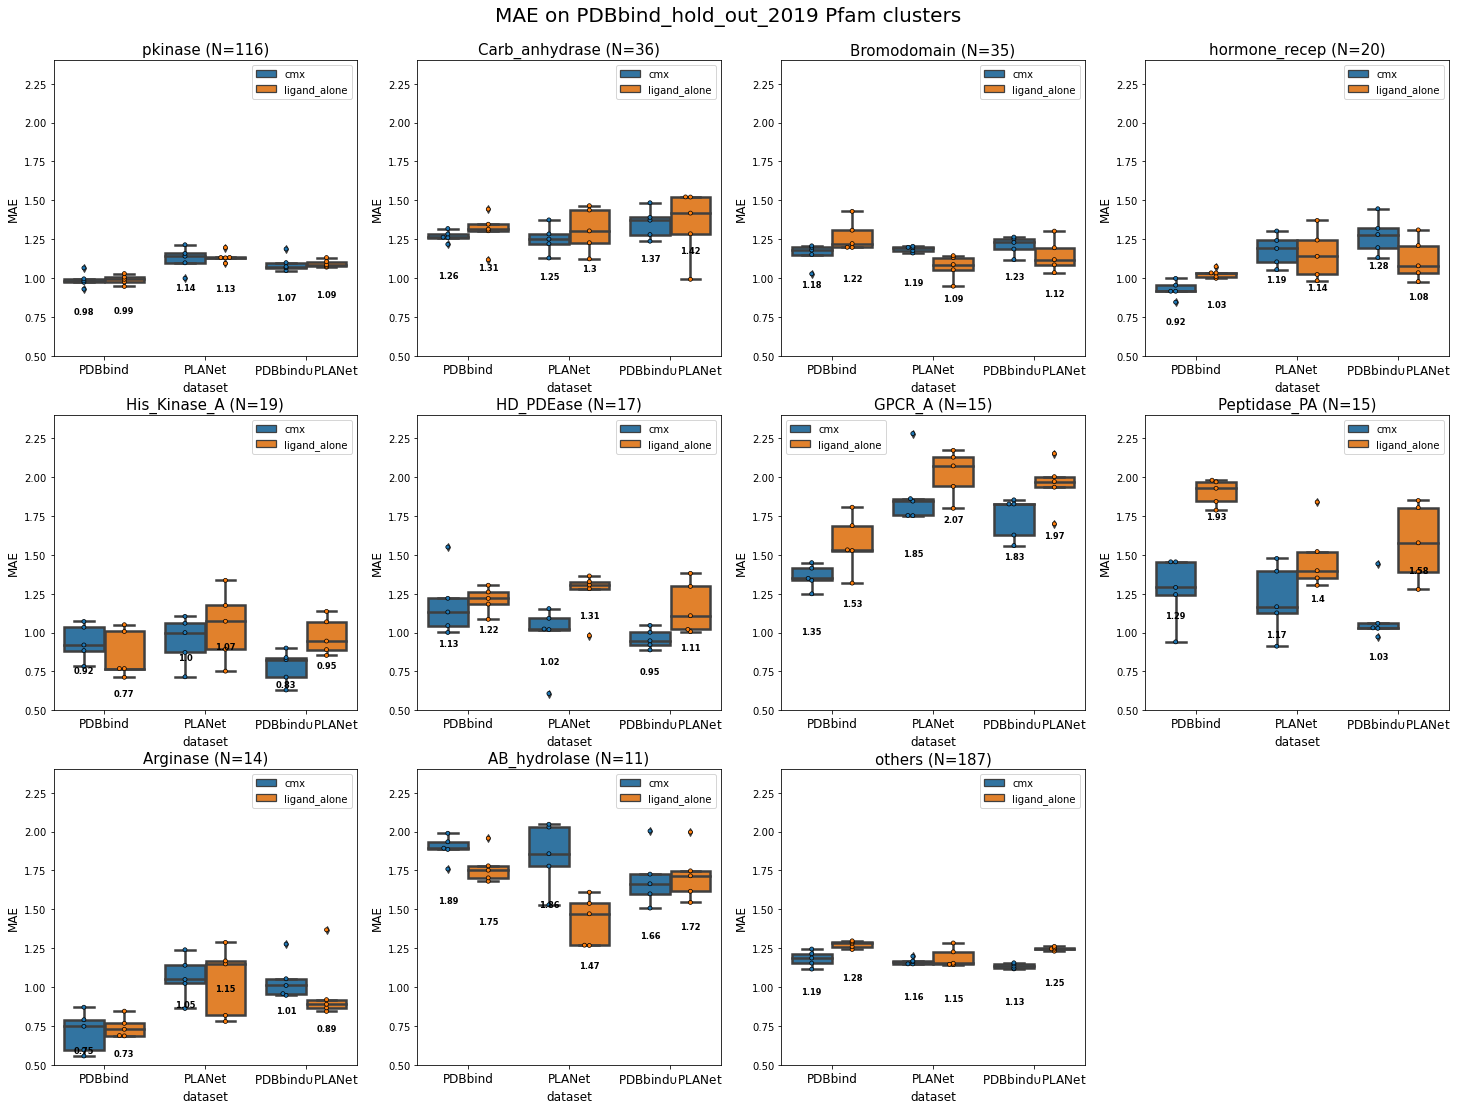

In [67]:
metric='mae'
fig = plt.figure(figsize=(25,25))
for i, cluster in enumerate(top10_clusters+['others']):
    cluster_sum_df = pfam_sum_df[pfam_sum_df['cluster']==cluster]
    grouped_median_cluster = cluster_sum_df.groupby(['dataset', 'type']).median().reset_index()
    grouped_median_cluster['model_name'] = [f'{row.dataset}_{row.type}' for row in grouped_median_cluster.itertuples()]
    
    ax = fig.add_subplot(4, 4, i+1)
    sns.boxplot(x="dataset", y=metric, data=cluster_sum_df, hue="type", order = models, linewidth=2.5)
    sns.swarmplot(x="dataset", y=metric, data=cluster_sum_df, hue="type", order = models, size = 4, dodge=True, edgecolor="black", linewidth=0.7)

    ax.set_title(f'{cluster} (N={cluster_11_count[cluster]})', fontsize=15)
    # fig.autofmt_xdate()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2])
    vertical_offset = cluster_sum_df[metric].median() * 0.2 # offset from median for display
    for i, modl in enumerate(models):
        for tp in ['cmx', 'ligand_alone']:
            median_metric = round(grouped_median_cluster.loc[(grouped_median_cluster['model_name'] == f'{modl}_{tp}')][metric].values[0], 2)
            if cluster=='Peptidase_PA':
                if tp == 'cmx':
                    ax.text(i-.2, median_metric-0.2, median_metric, horizontalalignment='center',size='small', weight='semibold')
                else:
                    ax.text(i+.2, median_metric-0.2, median_metric, horizontalalignment='center',size='small',weight='semibold')
            else:
                if tp == 'cmx':
                    ax.text(i-.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
                else:
                    ax.text(i+.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
    ax.set_ylim(0.5,2.4)
    ax.set_xticklabels(['PDBbind', 'PLANet', 'PDBbind'+r'$\cup{}$' + 'PLANet'], fontsize=12)
    ax.set_ylabel('MAE', fontsize=12)
    ax.set_xlabel('dataset', fontsize=12)
plt.suptitle('MAE on PDBbind_hold_out_2019 Pfam clusters', y=0.91, fontsize=20)
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/pfam_cluster/top10_clusters_{metric}_mean_of_5_repeat_models.png', dpi=300, bbox_inches='tight')
# plt.close()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PDBbind_minimized_v18_subset_ligand_alone vs. PLANet_v18_ligand_alone: t-test independent samples, P_val:1.348e-04 t=-6.821e+00
PDBbind_minimized_v18_subset_cmx vs. PLANet_v18_cmx: t-test independent samples, P_val:1.357e-02 t=-3.152e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PDBbind_minimized_v18_subset_ligand_alone vs. PLANet_v18_ligand_alone: t-test independent samples, P_val:9.434e-01 t=-7.327e-02
PDBbind_minimized_v18_subset_cmx vs. PLANet_v18_cmx: t-test independent samples, P_val:7.100e-01 t=3.853e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ***

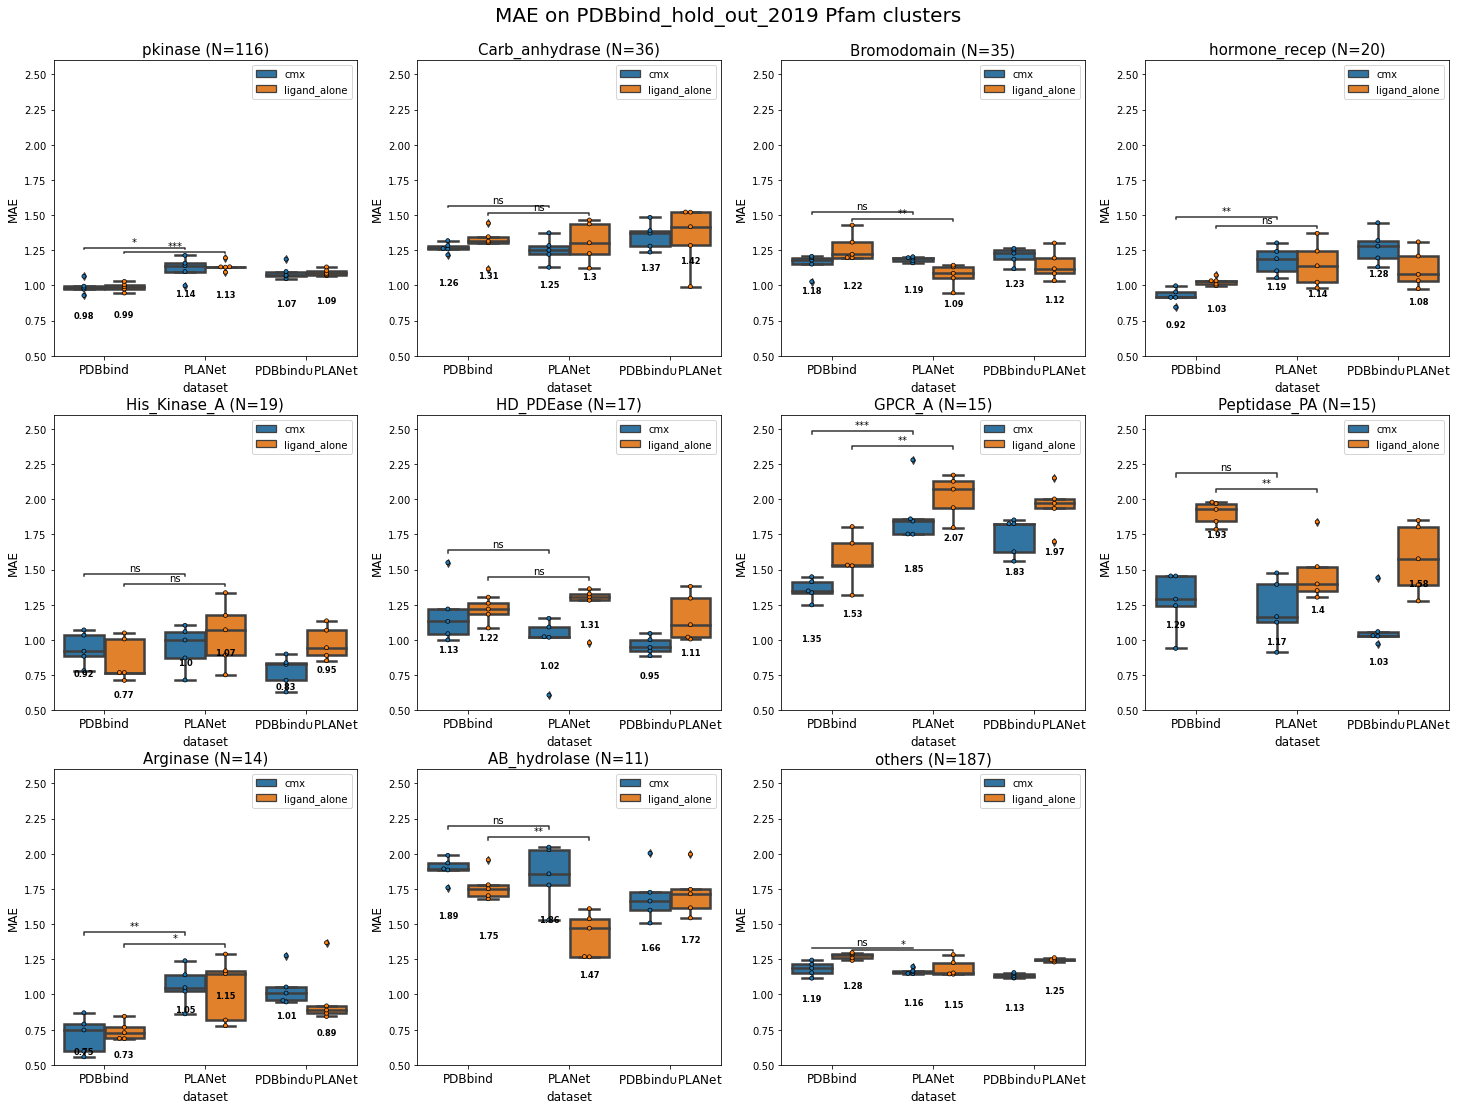

In [185]:
metric='mae'
fig = plt.figure(figsize=(25,25))
for i, cluster in enumerate(top10_clusters+['others']):
    cluster_sum_df = pfam_sum_df[pfam_sum_df['cluster']==cluster]
    grouped_median_cluster = cluster_sum_df.groupby(['dataset', 'type']).median().reset_index()
    grouped_median_cluster['model_name'] = [f'{row.dataset}_{row.type}' for row in grouped_median_cluster.itertuples()]
    
    ax = fig.add_subplot(4, 4, i+1)
    sns.boxplot(x="dataset", y=metric, data=cluster_sum_df, hue="type", order = models, linewidth=2.5)
    sns.swarmplot(x="dataset", y=metric, data=cluster_sum_df, hue="type", order = models, size = 4, dodge=True, edgecolor="black", linewidth=0.7)

    pairs = [(("PLANet_v18", "ligand_alone"), ("PDBbind_minimized_v18_subset", "ligand_alone")), 
        (("PLANet_v18", "cmx"), ("PDBbind_minimized_v18_subset", "cmx")), 
        ]
    annotator = Annotator(ax, pairs, x="dataset", y=metric, data=cluster_sum_df, hue="type", order = models)
    annotator.configure(test='t-test_ind').apply_and_annotate()

    ax.set_title(f'{cluster} (N={cluster_11_count[cluster]})', fontsize=15)
    # fig.autofmt_xdate()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2])
    vertical_offset = cluster_sum_df[metric].median() * 0.2 # offset from median for display
    for i, modl in enumerate(models):
        for tp in ['cmx', 'ligand_alone']:
            median_metric = round(grouped_median_cluster.loc[(grouped_median_cluster['model_name'] == f'{modl}_{tp}')][metric].values[0], 2)
            if cluster=='Peptidase_PA':
                if tp == 'cmx':
                    ax.text(i-.2, median_metric-0.2, median_metric, horizontalalignment='center',size='small', weight='semibold')
                else:
                    ax.text(i+.2, median_metric-0.2, median_metric, horizontalalignment='center',size='small',weight='semibold')
            else:
                if tp == 'cmx':
                    ax.text(i-.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
                else:
                    ax.text(i+.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
    ax.set_ylim(0.5,2.6)
    ax.set_xticklabels(['PDBbind', 'PLANet', 'PDBbind'+r'$\cup{}$' + 'PLANet'], fontsize=12)
    ax.set_ylabel('MAE', fontsize=12)
    ax.set_xlabel('dataset', fontsize=12)
plt.suptitle('MAE on PDBbind_hold_out_2019 Pfam clusters', y=0.91, fontsize=20)
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/pfam_cluster/top10_clusters_{metric}_mean_of_5_repeat_models_with_sig.png', dpi=300, bbox_inches='tight')
# plt.close()

# mean_predicted - property

In [79]:
# list(mean_pred_df.columns.drop(['unique_identify', 'y_true']))

['PDBbind_minimized_v18_subset_cmx_mean',
 'PDBbind_minimized_v18_subset_lig_alone_mean',
 'PLANet_v18_cmx_mean',
 'PLANet_v18_lig_alone_mean',
 'PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean',
 'PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean']

In [68]:
# mean_pred_df_with_prop

,unique_identify,y_true,PDBbind_minimized_v18_subset_cmx_mean,PDBbind_minimized_v18_subset_lig_alone_mean,PLANet_v18_cmx_mean,PLANet_v18_lig_alone_mean,PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean,PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean,mw,logp,rotb,hbd,hba,q,HA
0,5eng,5.85,6.118464,6.980225,5.603281,6.466641,5.494726,6.591030,471.554,0.16750,10.0,3.0,6.0,2.0,34.0
1,5ep7,5.40,4.287641,5.439884,5.191231,5.011604,5.331327,4.955045,271.252,0.00110,3.0,1.0,5.0,-1.0,20.0
2,5fxq,7.85,7.900875,8.166469,6.518389,7.342149,6.674024,8.371089,409.905,2.59152,4.0,2.0,7.0,1.0,29.0
3,5fxs,8.05,7.926687,8.313922,7.159188,7.725515,7.583177,7.946747,509.038,2.30964,6.0,2.0,8.0,1.0,36.0
4,5g2b,7.00,8.864078,8.259109,7.725052,6.264232,7.630954,7.382459,528.653,4.42880,7.0,2.0,5.0,0.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,6m9t,7.70,8.029396,7.308245,7.126153,6.324770,6.823287,7.008233,367.506,2.53050,13.0,2.0,5.0,-1.0,26.0
477,6ma5,8.10,6.220125,6.668172,7.052922,6.141025,6.013798,6.417132,540.599,1.39650,10.0,2.0,8.0,-1.0,37.0
478,6mrg,7.55,7.243981,7.061430,6.272728,6.625929,6.729782,6.603834,349.390,3.06030,5.0,2.0,6.0,0.0,26.0
479,6mx8,9.43,7.624122,7.440676,7.899214,8.114034,8.136658,8.277246,586.121,2.25580,8.0,4.0,7.0,2.0,40.0


In [69]:
PDBbind_v2020_cluster_sel.columns

Index(['pdb_id', 'PCV_cluster'], dtype='object')

In [71]:
mean_pred_df_with_prop_pfam = mean_pred_df_with_prop.merge(PDBbind_v2020_cluster_sel.rename(columns={'pdb_id': 'unique_identify'}), on=['unique_identify']).copy()
len(mean_pred_df_with_prop_pfam)

481

In [90]:
mean_pred_df_with_prop_pfam_sasa = mean_pred_df_with_prop_pfam.merge(PDBbind_hold_prop_sasa[['pdb_id', 'del_sasa']].rename(columns={'pdb_id': 'unique_identify'}), on=['unique_identify']).copy()
mean_pred_df_with_prop_pfam_sasa.shape

(481, 17)

In [83]:
from pathlib import Path

In [98]:
min([min(hold_out_cluster_mean_pred[name]) for name in list(mean_pred_df.columns.drop(['unique_identify', 'y_true']))])

5.942665100097656

In [99]:
max([max(hold_out_cluster_mean_pred[name]) for name in list(mean_pred_df.columns.drop(['unique_identify', 'y_true']))])

9.38348560333252

In [100]:
cluster_dict = defaultdict(list)
for cluster in top10_clusters:
    cluster_dir = f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/{cluster}'
    if not Path(cluster_dir).exists():
        Path(cluster_dir).mkdir(parents=True)
    
    hold_out_cluster_mean_pred = mean_pred_df_with_prop_pfam_sasa[mean_pred_df_with_prop_pfam_sasa['PCV_cluster']==cluster].copy()

    hold_out_cluster_mean_pred_melted = hold_out_cluster_mean_pred[['unique_identify', 'y_true', 'PDBbind_minimized_v18_subset_cmx_mean', 'PLANet_v18_cmx_mean']].melt(id_vars=['unique_identify', 'y_true'], var_name='model')
    fig, ax = plt.subplots(figsize=(6,6))
    sns.scatterplot(data=hold_out_cluster_mean_pred_melted, x="y_true", y="value", hue='model')
    lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()]),
        ]
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
    plt.xlabel("Experimental pAffi")
    plt.ylabel("mean_predicted pAffi")
    plt.title(f'PDBbind_hold_out_2019 {cluster} cluster (N={len(hold_out_cluster_mean_pred)})')
    handles, labels = ax.get_legend_handles_labels()
    # ax.legend(handles[:2], labels[:2], loc='upper left')
    PDBbind_v18_subset_Rp = round(stats.pearsonr(hold_out_cluster_mean_pred["y_true"], hold_out_cluster_mean_pred["PDBbind_minimized_v18_subset_cmx_mean"])[0], 3)
    PLANet_v18_Rp = round(stats.pearsonr(hold_out_cluster_mean_pred["y_true"], hold_out_cluster_mean_pred["PLANet_v18_cmx_mean"])[0], 3)

    ax.legend(handles[:2], [f'PDBbind_v18_subset_cmx_mean_Rp_{PDBbind_v18_subset_Rp}_MAE_{round(mean_absolute_error(hold_out_cluster_mean_pred["y_true"], hold_out_cluster_mean_pred["PDBbind_minimized_v18_subset_cmx_mean"]), 3)}', f'PLANet_v18_cmx_mean_Rp_{PLANet_v18_Rp}_MAE_{round(mean_absolute_error(hold_out_cluster_mean_pred["y_true"], hold_out_cluster_mean_pred["PLANet_v18_cmx_mean"]), 3)}'], loc='lower right')
    plt.savefig(f'{cluster_dir}/{cluster}_scatter_PLANet_vs_PIP_cmx_mean.png', dpi=300, bbox_inches='tight')
    plt.close()

    cluster_dict[cluster] = [round(stats.pearsonr(hold_out_cluster_mean_pred["y_true"], hold_out_cluster_mean_pred[name])[0], 3) for name in list(mean_pred_df.columns.drop(['unique_identify', 'y_true'])) ]

    for prop in ['mw', 'logp', 'HA', 'del_sasa']:
        fig, ax = plt.subplots(figsize=(6,6))
        sns.regplot(data=hold_out_cluster_mean_pred, x=prop, y="y_true")

        plt.xlabel(prop)
        plt.ylabel("Experimental pAffi")
        prop_true_Rp = round(stats.pearsonr(hold_out_cluster_mean_pred[prop], hold_out_cluster_mean_pred["y_true"])[0], 3)
        plt.title(f'PLANet_hold_out_2019 {cluster} cluster (N={len(hold_out_cluster_mean_pred)})\nRp={prop_true_Rp}, Rs={round(stats.spearmanr(hold_out_cluster_mean_pred[prop], hold_out_cluster_mean_pred["y_true"])[0], 3)}')
        handles, labels = ax.get_legend_handles_labels()
        # ax.legend(handles[:2], labels[:2], loc='upper left')
        plt.ylim(
            min([min(hold_out_cluster_mean_pred[name]) for name in list(mean_pred_df.columns.drop(['unique_identify', 'y_true']))])-0.5,
            max([max(hold_out_cluster_mean_pred[name]) for name in list(mean_pred_df.columns.drop(['unique_identify', 'y_true']))])+0.5
        )
        plt.savefig(f'{cluster_dir}/{cluster}_scatter_{prop}_experimental_pAffi.png', dpi=300, bbox_inches='tight')
        plt.close()

        cluster_dict[cluster].append(prop_true_Rp)

        fig = plt.figure(figsize=(16,16))
        for i, model in enumerate(models):
            for j, tp in enumerate(tps):
                # print((i+1)+6*j)
                ax = fig.add_subplot(3, 3, (i+1)+3*j)
                # fig, ax = plt.subplots(figsize=(6,6))
                # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
                sns.regplot(x=prop, y=f'{model}_{tp}_mean', data=hold_out_cluster_mean_pred)

                # ax.set_xlim(0, 600)
                ax.set_ylim(
                    min([min(hold_out_cluster_mean_pred[name]) for name in list(mean_pred_df.columns.drop(['unique_identify', 'y_true']))])-0.5,
                    max([max(hold_out_cluster_mean_pred[name]) for name in list(mean_pred_df.columns.drop(['unique_identify', 'y_true']))])+0.5
                )
                ax.set_ylabel(f'mean_predicted pAffi')
                ax.set_xlabel(prop)

                prop_mean_pred_Rp = round(stats.pearsonr(hold_out_cluster_mean_pred[f"{model}_{tp}_mean"], hold_out_cluster_mean_pred[prop])[0], 3)
                ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={prop_mean_pred_Rp}, spearmanr={round(stats.spearmanr(hold_out_cluster_mean_pred[f"{model}_{tp}_mean"], hold_out_cluster_mean_pred[prop])[0], 3)}')

        plt.subplots_adjust(left=0.125,
                            bottom=0.1, 
                            right=0.9, 
                            top=0.93, 
                            wspace=0.2, 
                            hspace=0.35)
        plt.suptitle(f'Relationship between mean_predict and {prop} on {cluster} cluster (N={len(hold_out_cluster_mean_pred)})')
        plt.savefig(f'{cluster_dir}/{prop}_pred_pAffi_for_6_models.png', dpi=300, bbox_inches='tight')
        plt.close()


In [120]:
mean_pred_df.columns.drop(['unique_identify', 'y_true'])

Index(['PDBbind_minimized_v18_subset_cmx_mean',
       'PDBbind_minimized_v18_subset_lig_alone_mean', 'PLANet_v18_cmx_mean',
       'PLANet_v18_lig_alone_mean',
       'PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean',
       'PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean'],
      dtype='object')

In [121]:
rename_dict = {'PDBbind_minimized_v18_subset_cmx_mean': 'Rp(PDBbind_v18_subset_cmx,Exp_pAffi)', 'PDBbind_minimized_v18_subset_lig_alone_mean': 'Rp(PDBbind_v18_subset_lig_alone,Exp_pAffi)', 'PLANet_v18_cmx_mean':'Rp(PLANet_cmx,Exp_pAffi)', 'PLANet_v18_lig_alone_mean':'Rp(PLANet_lig_alone,Exp_pAffi)', 'PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean':'Rp(merged_cmx,Exp_pAffi)', 'PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean':'Rp(merged_lig_alone,Exp_pAffi)', 'mw':'Rp(mw,Exp_pAffi)', 'logp':'Rp(logp,Exp_pAffi)', 'HA':'Rp(HA,Exp_pAffi)', 'del_sasa':'Rp(buried_SASA,Exp_pAffi)'}

In [122]:
prop_correlation = pd.DataFrame.from_dict(cluster_dict, orient='index', columns= list(mean_pred_df.columns.drop(['unique_identify', 'y_true'])) + ['mw', 'logp', 'HA', 'del_sasa'])
# list(mean_pred_df.columns.drop(['unique_identify', 'y_true'])) + ['mw', 'logp', 'HA', 'del_sasa']
# ['Rp(PDBbind_v18_subset_cmx,Exp_pAffi)', 'Rp(PDBbind_v18_subset_lig_alone,Exp_pAffi)', 'Rp(PLANet_cmx,Exp_pAffi)', 'Rp(PLANet_lig_alone,Exp_pAffi)', 'Rp(merged_cmx,Exp_pAffi)', 'Rp(merged_lig_alone,Exp_pAffi)', 'Rp(mw,Exp_pAffi)', 'Rp(logp,Exp_pAffi)', 'Rp(HA,Exp_pAffi)', 'Rp(buried_SASA,Exp_pAffi)']
prop_correlation

,PDBbind_minimized_v18_subset_cmx_mean,PDBbind_minimized_v18_subset_lig_alone_mean,PLANet_v18_cmx_mean,PLANet_v18_lig_alone_mean,PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean,PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean,mw,logp,HA,del_sasa
pkinase,0.548,0.476,0.466,0.449,0.483,0.470,0.396,0.146,0.441,0.457
Carb_anhydrase,0.186,0.158,0.349,0.494,0.269,0.406,-0.270,0.124,-0.280,-0.254
Bromodomain,0.345,0.311,0.370,0.490,0.349,0.436,0.150,0.480,0.164,0.190
hormone_recep,0.684,0.442,0.508,0.387,0.471,0.451,0.377,-0.179,0.428,0.243
His_Kinase_A,0.463,0.596,0.401,0.132,0.756,0.633,0.444,-0.438,0.456,0.361
HD_PDEase,0.500,0.331,0.761,0.632,0.721,0.687,0.058,0.222,0.022,-0.228
GPCR_A,0.057,0.031,-0.534,-0.187,0.056,-0.283,-0.427,0.033,-0.432,-0.302
Peptidase_PA,0.881,0.790,0.492,0.090,0.631,-0.072,0.421,-0.139,0.397,0.156
Arginase,0.460,0.551,0.146,0.001,0.110,0.520,0.748,-0.033,0.780,0.852
AB_hydrolase,0.260,0.630,0.305,0.797,0.345,0.502,0.571,0.001,0.591,0.222


In [109]:
stats.pearsonr(prop_correlation['Rp(buried_SASA,Exp_pAffi)'], prop_correlation['Rp(PDBbind_v18_subset_cmx,Exp_pAffi)'])

(0.4043212926717759, 0.24650388736973713)

In [113]:
stats.pearsonr(prop_correlation['Rp(mw,Exp_pAffi)'], prop_correlation['Rp(PDBbind_v18_subset_cmx,Exp_pAffi)'])

(0.583537982133939, 0.07656992475557027)

In [111]:
stats.pearsonr(prop_correlation['Rp(buried_SASA,Exp_pAffi)'], prop_correlation['Rp(PDBbind_v18_subset_lig_alone,Exp_pAffi)'])

(0.6434041788198711, 0.04473969644010544)

In [114]:
stats.pearsonr(prop_correlation['Rp(mw,Exp_pAffi)'], prop_correlation['Rp(PDBbind_v18_subset_lig_alone,Exp_pAffi)'])

(0.8784544929758282, 0.0008225086477796945)

In [110]:
stats.pearsonr(prop_correlation['Rp(buried_SASA,Exp_pAffi)'], prop_correlation['Rp(PLANet_cmx,Exp_pAffi)'])

(0.1504058499647806, 0.6783296247770045)

In [115]:
stats.pearsonr(prop_correlation['Rp(mw,Exp_pAffi)'], prop_correlation['Rp(PLANet_cmx,Exp_pAffi)'])

(0.41558611670264867, 0.23231520333382014)

In [112]:
stats.pearsonr(prop_correlation['Rp(buried_SASA,Exp_pAffi)'], prop_correlation['Rp(PLANet_lig_alone,Exp_pAffi)'])

(-0.13999686502603198, 0.6996887023971979)

In [116]:
stats.pearsonr(prop_correlation['Rp(mw,Exp_pAffi)'], prop_correlation['Rp(PLANet_lig_alone,Exp_pAffi)'])

(0.11909313579318065, 0.7431473753282066)

<AxesSubplot:xlabel='Rp(mw,Exp_pAffi)', ylabel='Rp(PDBbind_v18_subset_lig_alone,Exp_pAffi)'>

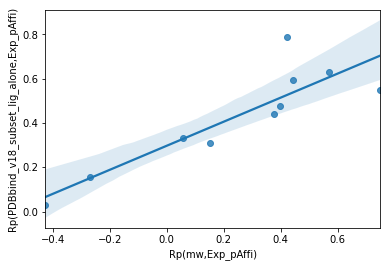

In [117]:
sns.regplot(data=prop_correlation, x='Rp(mw,Exp_pAffi)', y='Rp(PDBbind_v18_subset_lig_alone,Exp_pAffi)')

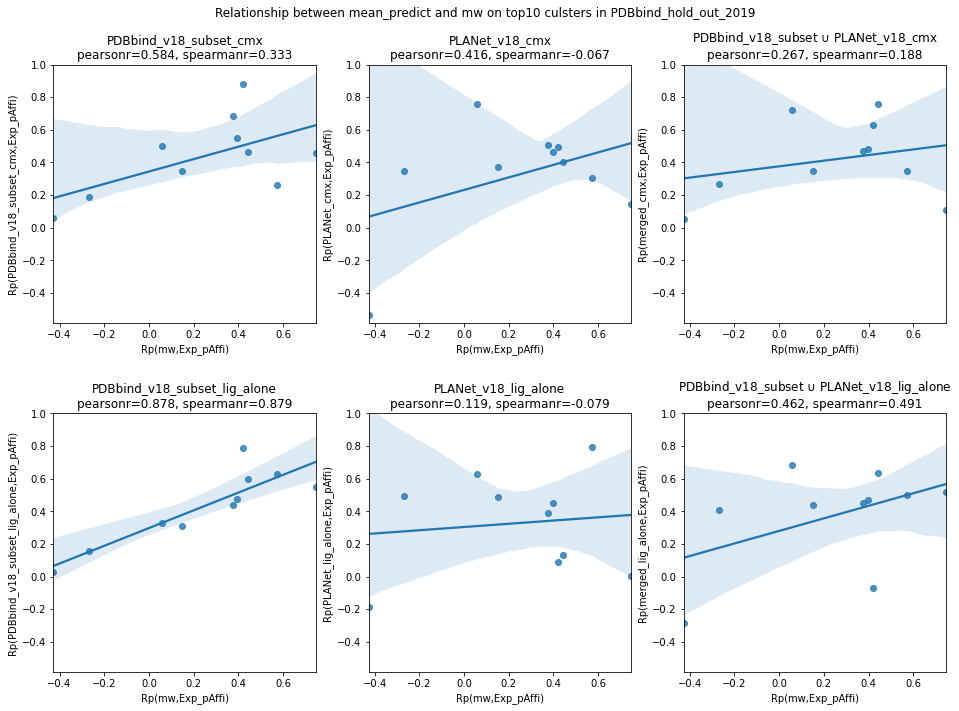

In [127]:
prop='mw'
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x=prop, y=f'{model}_{tp}_mean', data=prop_correlation)

        # ax.set_xlim(0, 600)
        ax.set_ylim(
            min([min(prop_correlation[name]) for name in list(mean_pred_df.columns.drop(['unique_identify', 'y_true']))])-0.05,
            1
        )
        ax.set_ylabel(rename_dict[f'{model}_{tp}_mean'])
        ax.set_xlabel(rename_dict[prop])

        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(prop_correlation[f"{model}_{tp}_mean"], prop_correlation[prop])[0], 3)}, spearmanr={round(stats.spearmanr(prop_correlation[f"{model}_{tp}_mean"], prop_correlation[prop])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and {prop} on top10 culsters in PDBbind_hold_out_2019')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/{prop}_relate_with_6_models.png', dpi=300, bbox_inches='tight')

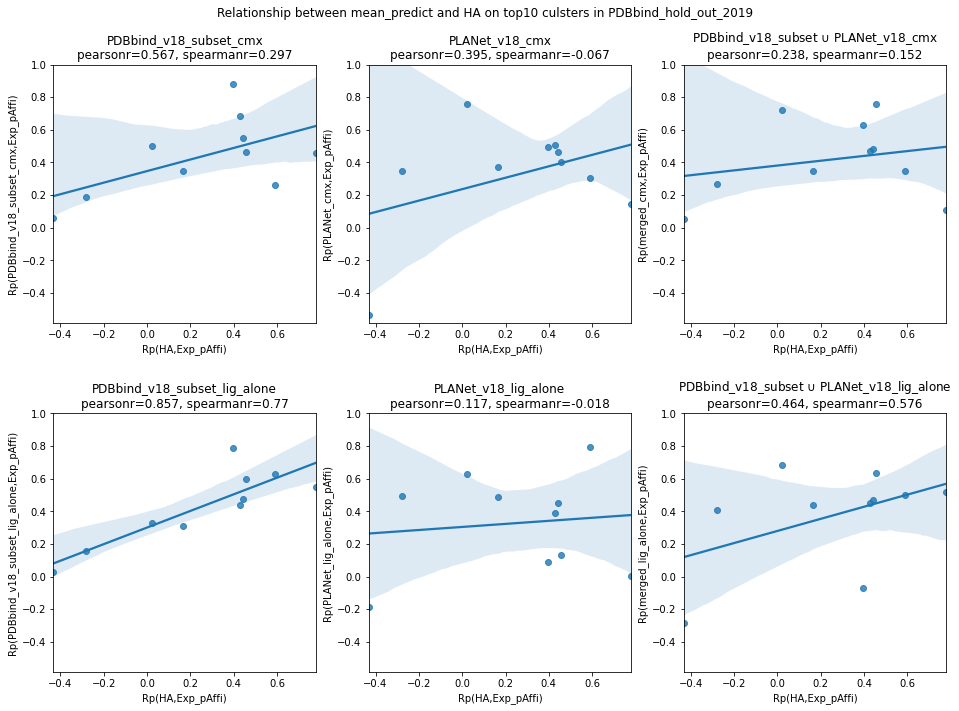

In [128]:
prop='HA'
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x=prop, y=f'{model}_{tp}_mean', data=prop_correlation)

        # ax.set_xlim(0, 600)
        ax.set_ylim(
            min([min(prop_correlation[name]) for name in list(mean_pred_df.columns.drop(['unique_identify', 'y_true']))])-0.05,
            1
        )
        ax.set_ylabel(rename_dict[f'{model}_{tp}_mean'])
        ax.set_xlabel(rename_dict[prop])

        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(prop_correlation[f"{model}_{tp}_mean"], prop_correlation[prop])[0], 3)}, spearmanr={round(stats.spearmanr(prop_correlation[f"{model}_{tp}_mean"], prop_correlation[prop])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and {prop} on top10 culsters in PDBbind_hold_out_2019')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/{prop}_relate_with_6_models.png', dpi=300, bbox_inches='tight')

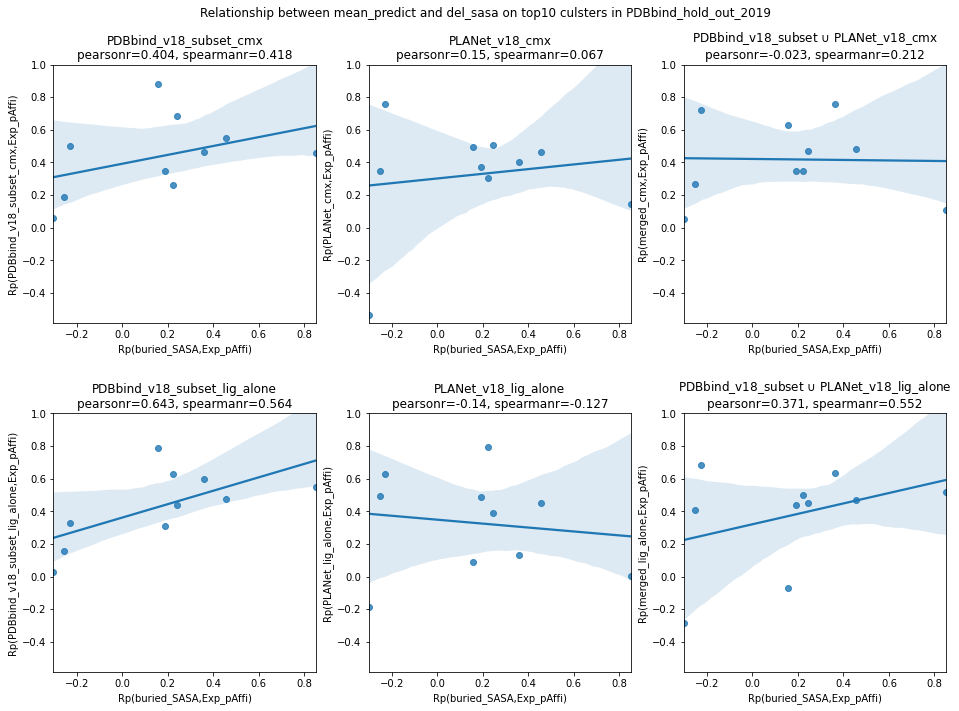

In [130]:
prop='del_sasa'
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x=prop, y=f'{model}_{tp}_mean', data=prop_correlation)

        # ax.set_xlim(0, 600)
        ax.set_ylim(
            min([min(prop_correlation[name]) for name in list(mean_pred_df.columns.drop(['unique_identify', 'y_true']))])-0.05,
            1
        )
        ax.set_ylabel(rename_dict[f'{model}_{tp}_mean'])
        ax.set_xlabel(rename_dict[prop])

        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(prop_correlation[f"{model}_{tp}_mean"], prop_correlation[prop])[0], 3)}, spearmanr={round(stats.spearmanr(prop_correlation[f"{model}_{tp}_mean"], prop_correlation[prop])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and {prop} on top10 culsters in PDBbind_hold_out_2019')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/{prop}_relate_with_6_models.png', dpi=300, bbox_inches='tight')

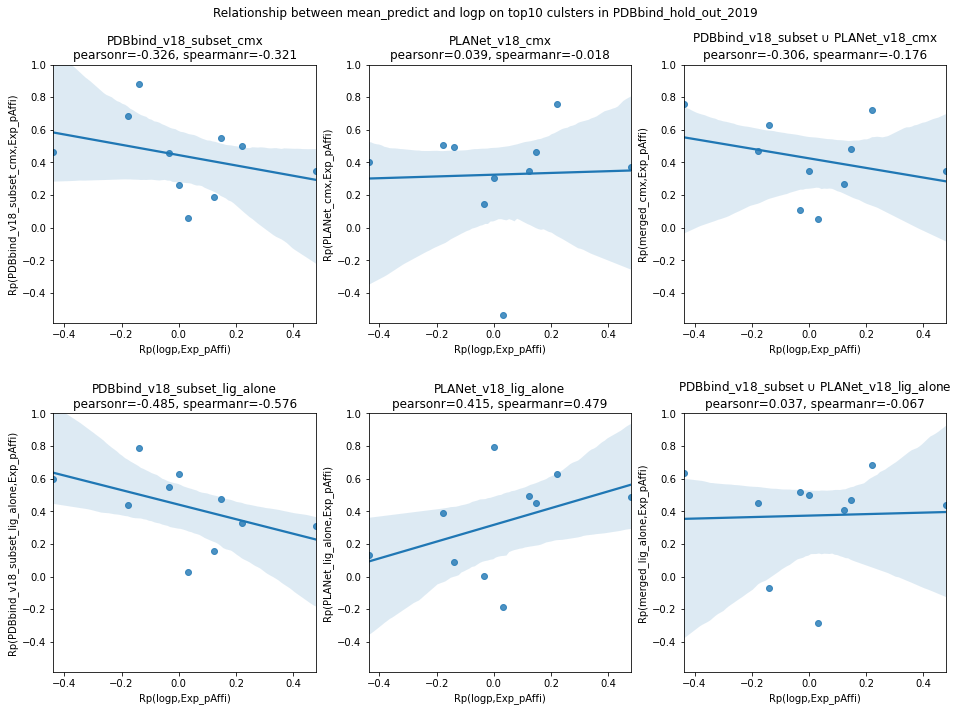

In [131]:
prop='logp'
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x=prop, y=f'{model}_{tp}_mean', data=prop_correlation)

        # ax.set_xlim(0, 600)
        ax.set_ylim(
            min([min(prop_correlation[name]) for name in list(mean_pred_df.columns.drop(['unique_identify', 'y_true']))])-0.05,
            1
        )
        ax.set_ylabel(rename_dict[f'{model}_{tp}_mean'])
        ax.set_xlabel(rename_dict[prop])

        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(prop_correlation[f"{model}_{tp}_mean"], prop_correlation[prop])[0], 3)}, spearmanr={round(stats.spearmanr(prop_correlation[f"{model}_{tp}_mean"], prop_correlation[prop])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and {prop} on top10 culsters in PDBbind_hold_out_2019')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/{prop}_relate_with_6_models.png', dpi=300, bbox_inches='tight')

# specific target

In [136]:
mean_pred_df_with_prop_pfam_sasa

,unique_identify,y_true,PDBbind_minimized_v18_subset_cmx_mean,PDBbind_minimized_v18_subset_lig_alone_mean,PLANet_v18_cmx_mean,PLANet_v18_lig_alone_mean,PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean,PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean,mw,logp,rotb,hbd,hba,q,HA,PCV_cluster,del_sasa
0,5eng,5.85,6.118464,6.980225,5.603281,6.466641,5.494726,6.591030,471.554,0.16750,10.0,3.0,6.0,2.0,34.0,Bromodomain,8.572350
1,5ep7,5.40,4.287641,5.439884,5.191231,5.011604,5.331327,4.955045,271.252,0.00110,3.0,1.0,5.0,-1.0,20.0,Bromodomain,5.938599
2,5fxq,7.85,7.900875,8.166469,6.518389,7.342149,6.674024,8.371089,409.905,2.59152,4.0,2.0,7.0,1.0,29.0,pkinase,7.929779
3,5fxs,8.05,7.926687,8.313922,7.159188,7.725515,7.583177,7.946747,509.038,2.30964,6.0,2.0,8.0,1.0,36.0,pkinase,8.780609
4,5g2b,7.00,8.864078,8.259109,7.725052,6.264232,7.630954,7.382459,528.653,4.42880,7.0,2.0,5.0,0.0,39.0,HD_PDEase,12.708481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,6m9t,7.70,8.029396,7.308245,7.126153,6.324770,6.823287,7.008233,367.506,2.53050,13.0,2.0,5.0,-1.0,26.0,GPCR_A,9.705536
477,6ma5,8.10,6.220125,6.668172,7.052922,6.141025,6.013798,6.417132,540.599,1.39650,10.0,2.0,8.0,-1.0,37.0,GT-B,8.113647
478,6mrg,7.55,7.243981,7.061430,6.272728,6.625929,6.729782,6.603834,349.390,3.06030,5.0,2.0,6.0,0.0,26.0,Amidase,9.067352
479,6mx8,9.43,7.624122,7.440676,7.899214,8.114034,8.136658,8.277246,586.121,2.25580,8.0,4.0,7.0,2.0,40.0,pkinase,10.826263


In [168]:
pepetidase_pa = mean_pred_df_with_prop_pfam_sasa[mean_pred_df_with_prop_pfam_sasa['PCV_cluster']=='Peptidase_PA'].copy()
pepetidase_pa.sort_values(by='y_true', inplace=True)

In [166]:
len(pepetidase_pa)

15

In [140]:
from rdkit.Chem import AllChem, PandasTools, rdFMCS, Draw, rdMolDescriptors
from rdkit import Chem
from rdkit import DataStructs

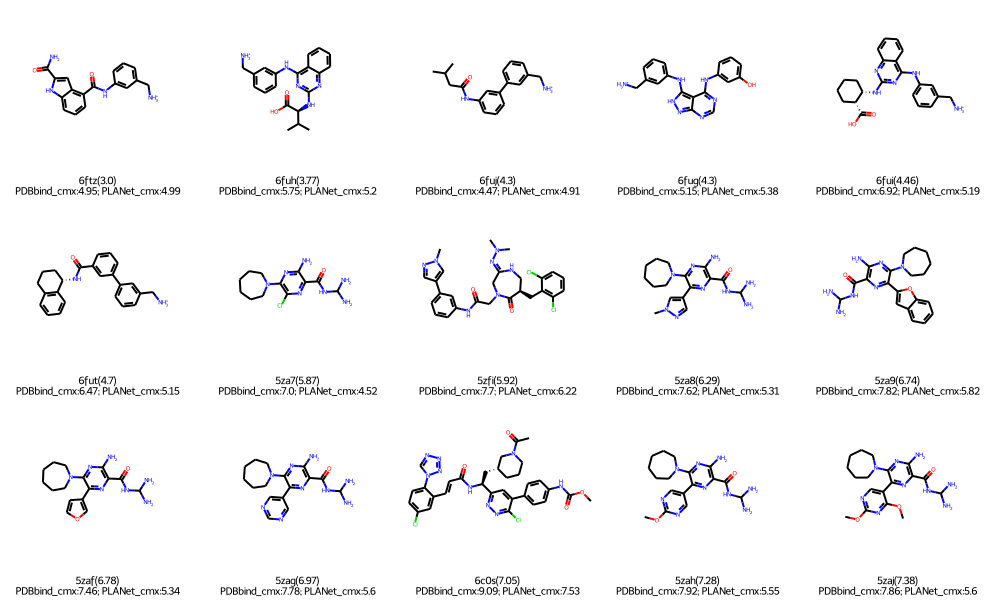

In [172]:
pepetidase_pa.sort_values(by='y_true', inplace=True)
Draw.MolsToGridImage([Chem.SmilesMolSupplier(f'/pubhome/xli02/Downloads/dataset/PDBbind/PDBbind_v2019/general_structure_only/{ui}/{ui}_ligand.smi', delimiter='\t', titleLine=False)[0] for ui in pepetidase_pa['unique_identify']], legends=[f'{row.unique_identify}({row.y_true})\nPDBbind_cmx:{round(row.PDBbind_minimized_v18_subset_cmx_mean,2)}; PLANet_cmx:{round(row.PLANet_v18_cmx_mean,2)}' for row in pepetidase_pa.itertuples()], molsPerRow=5, returnPNG=False, maxMols=len(pepetidase_pa))

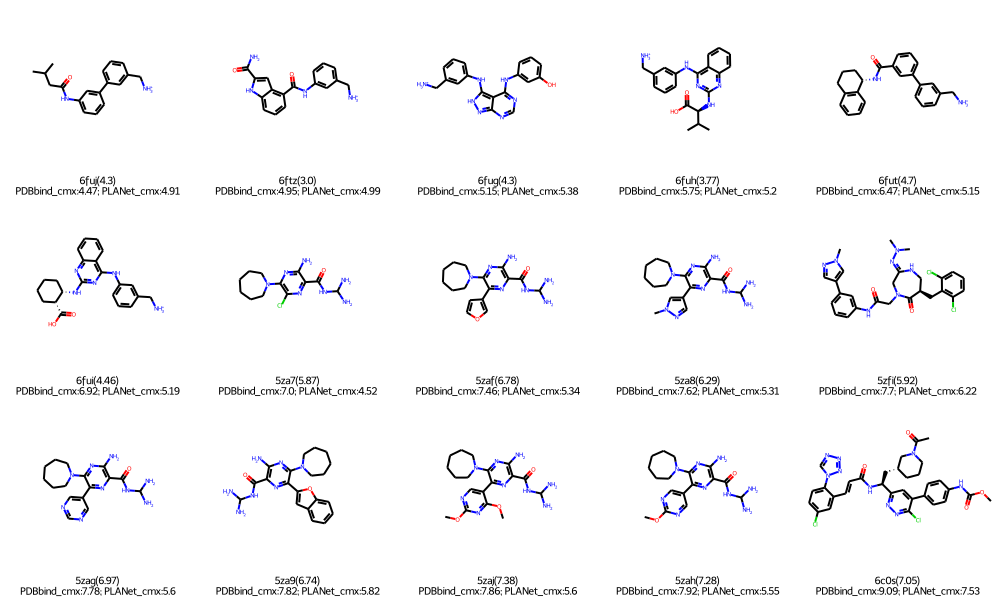

In [170]:
pepetidase_pa.sort_values(by='PDBbind_minimized_v18_subset_cmx_mean', inplace=True)
Draw.MolsToGridImage([Chem.SmilesMolSupplier(f'/pubhome/xli02/Downloads/dataset/PDBbind/PDBbind_v2019/general_structure_only/{ui}/{ui}_ligand.smi', delimiter='\t', titleLine=False)[0] for ui in pepetidase_pa['unique_identify']], legends=[f'{row.unique_identify}({row.y_true})\nPDBbind_cmx:{round(row.PDBbind_minimized_v18_subset_cmx_mean,2)}; PLANet_cmx:{round(row.PLANet_v18_cmx_mean,2)}' for row in pepetidase_pa.itertuples()], molsPerRow=5, returnPNG=False, maxMols=len(pepetidase_pa))

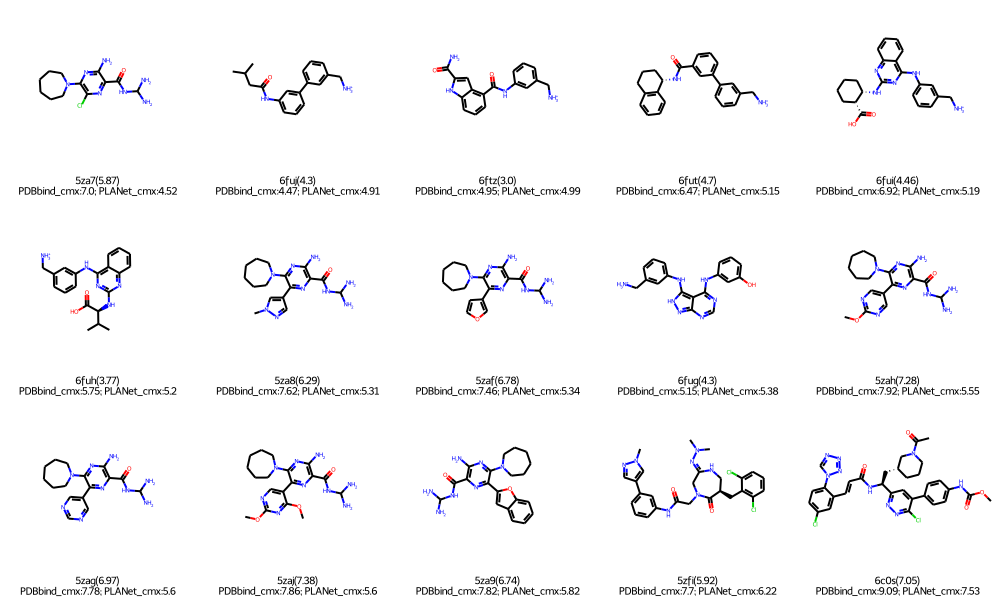

In [171]:
pepetidase_pa.sort_values(by='PLANet_v18_cmx_mean', inplace=True)
Draw.MolsToGridImage([Chem.SmilesMolSupplier(f'/pubhome/xli02/Downloads/dataset/PDBbind/PDBbind_v2019/general_structure_only/{ui}/{ui}_ligand.smi', delimiter='\t', titleLine=False)[0] for ui in pepetidase_pa['unique_identify']], legends=[f'{row.unique_identify}({row.y_true})\nPDBbind_cmx:{round(row.PDBbind_minimized_v18_subset_cmx_mean,2)}; PLANet_cmx:{round(row.PLANet_v18_cmx_mean,2)}' for row in pepetidase_pa.itertuples()], molsPerRow=5, returnPNG=False, maxMols=len(pepetidase_pa))